In [ ]:
#pip install tensorflow keras numpy skimage matplotlib
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
plt.style.use('fivethirtyeight')

# Import Data

In [ ]:
#Load the data
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
#Print the data type of x_train
print(type(x_train))
#Print the data type of y_train
print(type(y_train))
#Print the data type of x_test
print(type(x_test))
#Print the data type of y_test
print(type(y_test))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
#Get the shape of x_train
print('x_train shape:', x_train.shape)#Get the shapeofy_train
print('y_train shape:', y_train.shape)#Get the shapeofx_train
print('x_test shape:', x_test.shape)#Get the shape of y_train
print('y_test shape:', y_test.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


array([[[53, 65, 53],
        [54, 63, 52],
        [56, 60, 50],
        ...,
        [47, 51, 50],
        [41, 45, 44],
        [24, 28, 27]],

       [[46, 59, 41],
        [53, 62, 45],
        [54, 59, 44],
        ...,
        [42, 46, 45],
        [39, 43, 42],
        [28, 32, 31]],

       [[45, 59, 38],
        [50, 60, 41],
        [46, 52, 34],
        ...,
        [38, 42, 41],
        [36, 40, 39],
        [29, 33, 32]],

       ...,

       [[71, 83, 66],
        [74, 83, 66],
        [80, 85, 67],
        ...,
        [51, 54, 33],
        [46, 49, 34],
        [49, 50, 41]],

       [[75, 82, 67],
        [79, 85, 69],
        [81, 85, 67],
        ...,
        [61, 65, 41],
        [64, 67, 48],
        [48, 50, 41]],

       [[85, 83, 71],
        [85, 84, 71],
        [86, 86, 70],
        ...,
        [61, 65, 39],
        [64, 67, 46],
        [49, 50, 41]]], dtype=uint8)
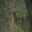

In [ ]:
index=10
x_train[index]

In [ ]:
classification = ['airplane', 'automobile', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']#Printtheimage class
print('The image class is: ', classification[y_train[index][0]])

The image class is:  deer


The image label is:  [6]
The image class is:  frog


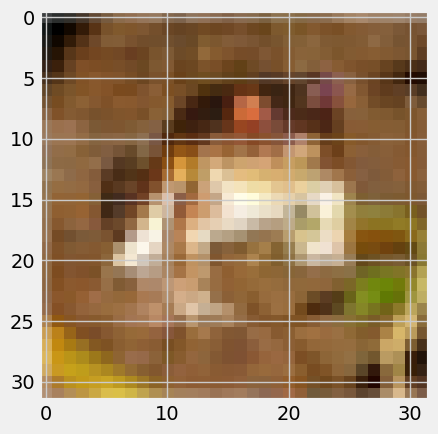

In [ ]:
index=0
x_train[index]
img = plt.imshow(x_train[index])
print('The image label is: ', y_train[index])
print('The image class is: ', classification[y_train[index][0]])

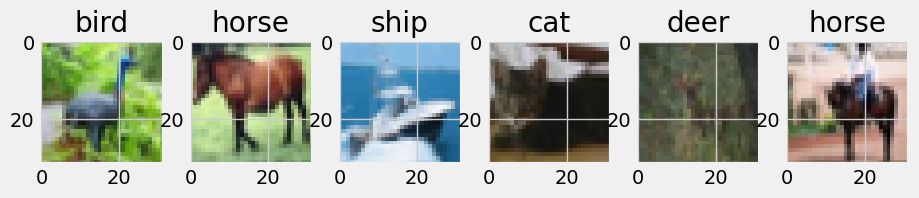

In [ ]:
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(10, 6))

for _ax, sample, label in zip(ax, x_train[6:12], y_train[6:12]):
    img = sample
    _ax.imshow(img,cmap='gray')
    _ax.set_title(classification[label[0]])

# Function

In [ ]:
def split_data(data_X, data_Y):
  # Train/validation/test split(70% train, 20% validation, 10% test)
  return train_test_split(data_X, data_Y, test_size=0.2, random_state=128)

In [ ]:
def make_dataset(ndarrayX, ndarrayY, flatten=False, batch_size=None):

    ds_x = tf.data.Dataset.from_tensor_slices(ndarrayX)
    #ds_x = ds_x.map(lambda x: tf.io.read_file(x))
    #ds_x = ds_x.map(lambda x: tf.image.decode_png(x))
    ds_x = ds_x.map(lambda x: x / 255)

    if flatten:
        ds_x = ds_x.map(lambda x: tf.reshape(x, (784,)))
    else:
        ds_x = ds_x.map(lambda x: tf.reshape(x, (32, 32, 3)))



    ds_y = tf.data.Dataset.from_tensor_slices(ndarrayY)

    ds = tf.data.Dataset.zip((ds_x, ds_y))

    if batch_size:
        ds = ds.batch(batch_size, drop_remainder=True)
    return ds


#train_ds = make_dataset(x_train, y_train, batch_size=32)
#test_ds = make_dataset(x_test, y_test, batch_size=32)
#train_ds

In [ ]:
def preprocesing(x_train, y_train, x_test, y_test):
  X_train, x_val, Y_train, y_val = split_data(x_train, y_train)
  train_ds = make_dataset(X_train, Y_train, batch_size=32)
  val_ds = make_dataset(x_val, y_val, batch_size=32)
  test_ds = make_dataset(x_test, y_test, batch_size=32)
  return train_ds, val_ds, test_ds

In [ ]:
def plot_visualization(history):
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def compare_optimazer_plot(results: dict, columns: str):
  df = pd.DataFrame(results).T.reset_index().rename(columns={'index':  columns})
  df_melted = df.melt(id_vars=[columns],
  value_vars=['loss','val_loss'],
  var_name='Metric', value_name='Value')
  plt.figure(figsize=(14, 7))
  sns.barplot(x=columns, y='Value', hue='Metric', data=df_melted)
  plt.title('Comparison of Loss and Validation Loss')
  plt.ylabel('Value')
  plt.xlabel(columns)
  plt.legend(title='Metric')
  df_melted = df.melt(id_vars=[columns], value_vars=['accuracy'],
  var_name='Metric', value_name='Value')
  plt.figure(figsize=(14, 7))
  sns.barplot(x=columns, y='Value', hue='Metric', data=df_melted)
  plt.title('Comparison of accuracy')
  plt.ylabel('Value')
  plt.xlabel(columns)
  plt.legend(title='Metric')
  plt.show()

def predict_model(model, tf_dataset):
    Y_pred = model.predict(tf_dataset, verbose=0)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in tf_dataset], axis=0)
    #Y_true = test_dataset.map(lambda x, y: y)
    return Y_true, Y_pred_classes

def calculate_metrics(model, tf_dataset):
    Y_true, Y_pred_classes = predict_model(model, tf_dataset)
    precision = precision_score(Y_true, Y_pred_classes, average='weighted')
    recall = recall_score(Y_true, Y_pred_classes, average='weighted')
    f1 = f1_score(Y_true, Y_pred_classes, average='weighted')

    return precision, recall, f1

def plot_confusion_matrix(tf_dataset, labels, ds_type):
    actual, predicted = predict_model(model, tf_dataset)
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(12, 12)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [ ]:
from collections import defaultdict
def log_model_info(model, optimizer, epochs, test_loss, test_accuracy, precision, recall, f1, results):
    model_info = defaultdict(list)

    # Додаємо основні параметри
    for layer in model.layers:
        config = layer.get_config()

        # Збираємо інформацію про кожен шар
        if 'Conv2D' in layer.__class__.__name__:
            model_info['Conv2D_filters'].append(config['filters'])
            model_info['Conv2D_kernel_size'].append(config['kernel_size'])
        elif 'Dense' in layer.__class__.__name__:
            model_info['Dense_units'].append(config['units'])
        elif 'Dropout' in layer.__class__.__name__:
            model_info['Dropout_rate'].append(config['rate'])
        elif 'BatchNormalization' in layer.__class__.__name__:
            model_info['BatchNormalization'].append(True)
        elif 'MaxPooling2D' in layer.__class__.__name__:
            model_info['MaxPooling2D'].append(config['pool_size'])

    # Додаємо оптимізатор, кількість епох, кількість параметрів
    model_info['optimizer'] = optimizer.name
    model_info['learning_rate'] =  float(optimizer.learning_rate.numpy())
    model_info['epochs'] = epochs
    model_info['test_loss'] = test_loss
    model_info['test_accuracy'] = test_accuracy
    model_info['precision'] = precision
    model_info['recall'] = recall
    model_info['f1'] = f1
    model_info['total_params'] = model.count_params()

    # Додаємо результати у загальний список
    results.append(model_info)

In [ ]:
def display_images(dataset, num_images=15):
    plt.figure(figsize=(8, 6))
    for i, (images, labels) in enumerate(dataset.take(num_images)):
        # Отримання першого зображення з кожного батчу
        image = images[0]
        label = labels[0]
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(image.numpy())
        plt.title(classification[label[0]])
        plt.axis("off")
    plt.show()

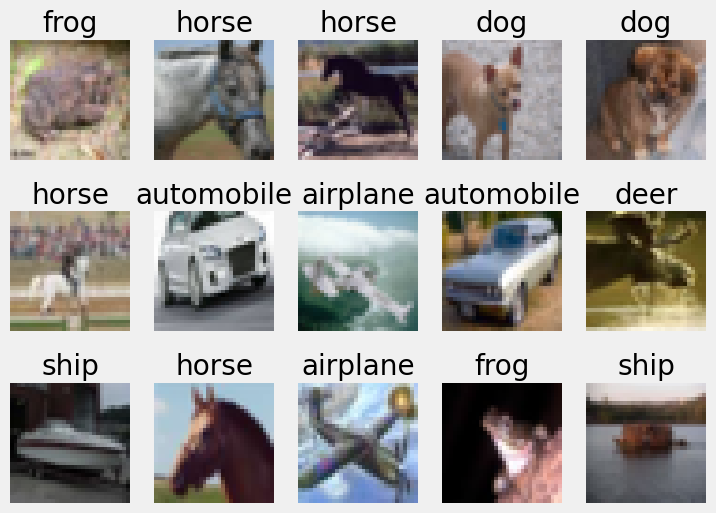

In [ ]:
train_dataset, val_dataset, test_dataset = preprocesing(x_train, y_train, x_test, y_test)
display_images(train_dataset)

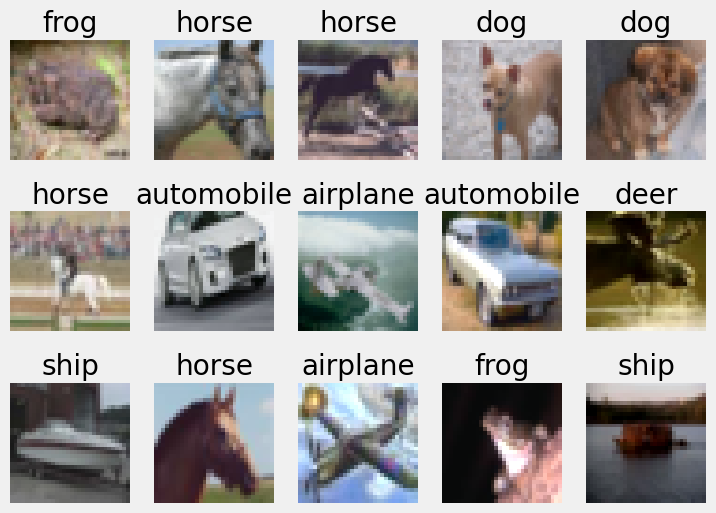

In [ ]:
train_ds_augment = train_dataset.map(augment)
display_images(train_ds_augment)

# Training_CNN

In [ ]:
results = []
def training_CNN(model,train_X, train_Y, X_test, Y_test, epochs=5):
      print(f"Training model CNN")
      train_dataset, val_dataset, test_dataset = preprocesing(train_X, train_Y, X_test, Y_test)

      optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
      # Компіляція моделі
      model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
      # Перевіряємо структуру моделі
      model.summary()

      # Set a learning rate annealer
      reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                          patience=1,
                          verbose=1,
                          factor=0.5,
                          min_lr=1e-6)

      train_ds_augment = train_dataset.map(augment)
      history = model.fit(
          train_ds_augment,
          validation_data= val_dataset,
          epochs = epochs,
          callbacks=[reduce_lr]
      )
      plot_visualization(history)

      test_loss, test_accuracy = model.evaluate(test_dataset)
      precision, recall, f1 = calculate_metrics(model, test_dataset)
      plot_confusion_matrix(test_dataset, classification, 'training')

      log_model_info(model, optimizer, epochs, test_loss, test_accuracy, precision, recall, f1, results)
      print(f"Test Accuracy: {test_accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
      print("-" * 60)

# Model

In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2

class MyConvLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=(3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001), pool_size=(2, 2), dropout_rate=None):
        super().__init__()

        self.conv2D = Conv2D(filters, kernel_size, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)
        self.activ = Activation('relu')
        self.norm = BatchNormalization()
        if pool_size:
            self.max_pool = MaxPooling2D(pool_size=pool_size)
        if dropout_rate:
            self.droup = Dropout(dropout_rate)

    def call(self, inputs):
        x = self.conv2D(inputs)
        x = self.activ(x)
        x = self.norm(x)
        if self.max_pool:
            x = self.max_pool(x)
        if self.droup:
            x = self.droup(x)
        return x

# Створюємо клас моделі з використанням Subclassing API
class CustomCNN(tf.keras.Model):
    def __init__(self, conv_blocks, dense_units=512, dropout_rate=0.5, output_classes=10):
        super(CustomCNN, self).__init__()

        # Зберігаємо параметри
        self.conv_blocks = conv_blocks
        self.dense_units = dense_units
        self.dropout_rate = dropout_rate
        self.output_classes = output_classes

        # Створюємо згорткові блоки
        self.conv_layers = []
        for filters, kernel_size, dropout in self.conv_blocks:
          self.conv_layers.append(MyConvLayer(filters=filters, kernel_size=kernel_size, dropout_rate=dropout))

        # Фінальні шари
        self.flatten = Flatten()
        self.dense = Dense(self.dense_units, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001))
        self.dense_activation = Activation('relu')
        self.dropout = Dropout(self.dropout_rate)
        self.output_layer = Dense(self.output_classes, activation='softmax')

    # Метод виклику для проходження даних через модель
    def call(self, inputs, training=False):
        x = inputs

        # Проходимо через кожен згортковий блок
        for layer in self.conv_layers:
            x = layer(x)

        # Фінальні шари
        x = self.flatten(x)
        x = self.dense(x)
        x = self.dense_activation(x)
        x = self.dropout(x, training=training)  # Dropout застосовується тільки під час тренування
        return self.output_layer(x)

# Конфігурації згорткових блоків: (filters, kernel_size, dropout_rate)
conv_blocks = [
    (32, (3, 3), 0.2),
    (64, (3, 3), 0.3),
    (128, (3, 3), 0.4),
    (256, (3, 3), 0.5)
]

# Створюємо модель
model = CustomCNN(conv_blocks)

Training model CNN


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ my_conv_layer (MyConvLayer)          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_conv_layer_1 (MyConvLayer)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_conv_layer_2 (MyConvLayer)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_conv_layer_3 (MyConvLayer)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2588 - loss: 4.2871 - val_accuracy: 0.3577 - val_loss: 3.8187 - learning_rate: 0.0010
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4334 - loss: 2.6787 - val_accuracy: 0.4903 - val_loss: 2.3993 - learning_rate: 0.0010
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5115 - loss: 2.1229 - val_accuracy: 0.5789 - val_loss: 1.8712 - learning_rate: 0.0010
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5616 - loss: 1.9493 - val_accuracy: 0.5876 - val_loss: 1.8857 - learning_rate: 0.0010
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.5992 - loss: 1.8825 - val_accuracy: 0.6363 - val_loss: 1.7913 - learning_rate: 0.0010
Epoch 6/25
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6141 - loss: 1.8407
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6141 - l

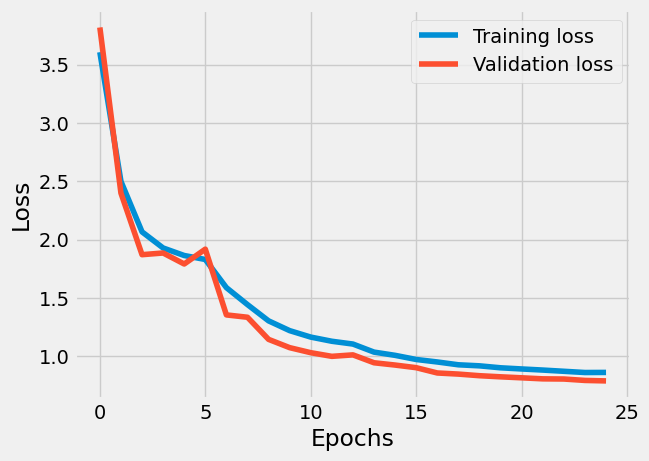

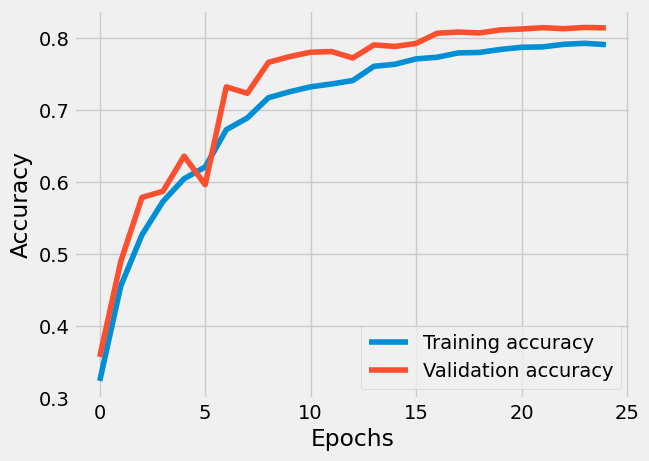

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8200 - loss: 0.7923


Model: "custom_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ my_conv_layer (MyConvLayer)          │ ?                           │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_conv_layer_1 (MyConvLayer)        │ ?                           │          18,752 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_conv_layer_2 (MyConvLayer)        │ ?                           │          74,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ my_conv_layer_3 (MyConvLayer)        │ ?                           │         296,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 1024)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 512)                   │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (32, 512)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (32, 512)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 10)                    │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,758,880 (10.52 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,838,614 (7.01 MB)

Test Accuracy: 0.8202123641967773, Precision: 0.8207850166376633, Recall: 0.8202123397435898, F1 Score: 0.8179921365045869
------------------------------------------------------------


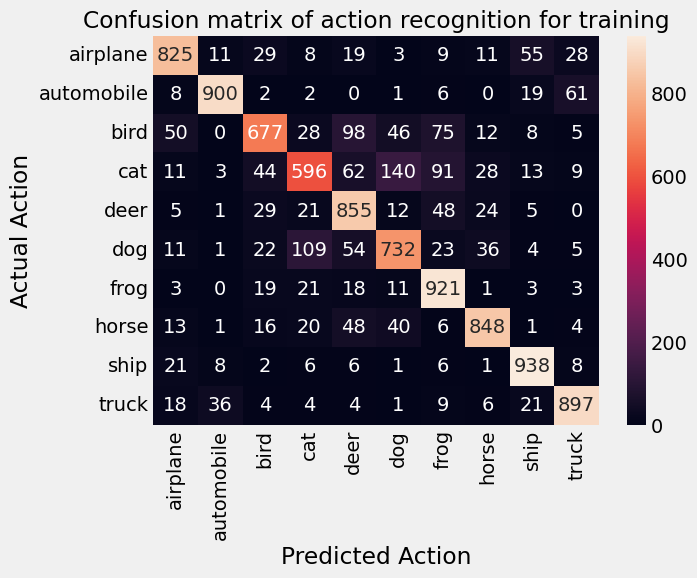

In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

In [ ]:
df = pd.DataFrame(results)
df

Dense_units                  Dropout_rate  \
0   [512, 10]                         [0.5]   
1   [512, 10]  [0.25, 0.25, 0.25, 0.5, 0.5]   

                                           optimizer  learning_rate  epochs  \
0  <keras.src.optimizers.adam.Adam object at 0x78...   7.812500e-06      25   
1  <keras.src.optimizers.adam.Adam object at 0x78...   1.000000e-06      25   

   test_loss  test_accuracy  precision    recall        f1  total_params  \
0   0.787112       0.820212   0.820785  0.820212  0.817992        920266   
1   0.668949       0.772135   0.773684  0.772135  0.769270        920266   

       Conv2D_filters                Conv2D_kernel_size  \
0                 NaN                               NaN   
1  [32, 64, 128, 256]  [(3, 3), (3, 3), (3, 3), (3, 3)]   

         BatchNormalization                      MaxPooling2D  
0                       NaN                               NaN  
1  [True, True, True, True]  [(2, 2), (2, 2), (2, 2), (2, 2)]

# Base MODEL

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

# Ініціалізація моделі
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.25))  # Dropout 25% для регуляризації


# Перший блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(64, (3, 3), padding='same'))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.25))  # Dropout 25% для регуляризації

# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(128, (3, 3), padding='same'))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Третій блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(256, (3, 3), padding='same'))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))  # Збільшуємо Dropout для глибших шарів

# Фінальна частина: Flatten -> Повністю зв'язаний шар -> ReLU -> Dropout -> Класифікаційний шар
model.add(Flatten())  # Перетворюємо 2D дані на 1D
model.add(Dense(512))  # Повністю зв’язаний шар із 512 нейронами
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout для запобігання перенавчанню

# Вихідний класифікаційний шар (Softmax для багатокласової класифікації)
model.add(Dense(10))  # 10 класів (наприклад, CIFAR-10)
model.add(Activation('softmax'))  # Softmax для ймовірнісного виходу

#optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Перевіряємо структуру моделі
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Training model CNN


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_11 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.2899 - loss: 2.2198 - val_accuracy: 0.3858 - val_loss: 1.8751 - learning_rate: 0.0010
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4599 - loss: 1.4911 - val_accuracy: 0.5637 - val_loss: 1.2138 - learning_rate: 0.0010
Epoch 3/25
1243/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5292 - loss: 1.3136
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.5293 - loss: 1.3134 - val_accuracy: 0.3172 - val_loss: 2.7499 - learning_rate: 0.0010
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5998 - loss: 1.1306 - val_accuracy: 0.6822 - val_loss: 0.9012 - learning_rate: 5.0000e-04
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6274 - loss: 1.0598
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6274 

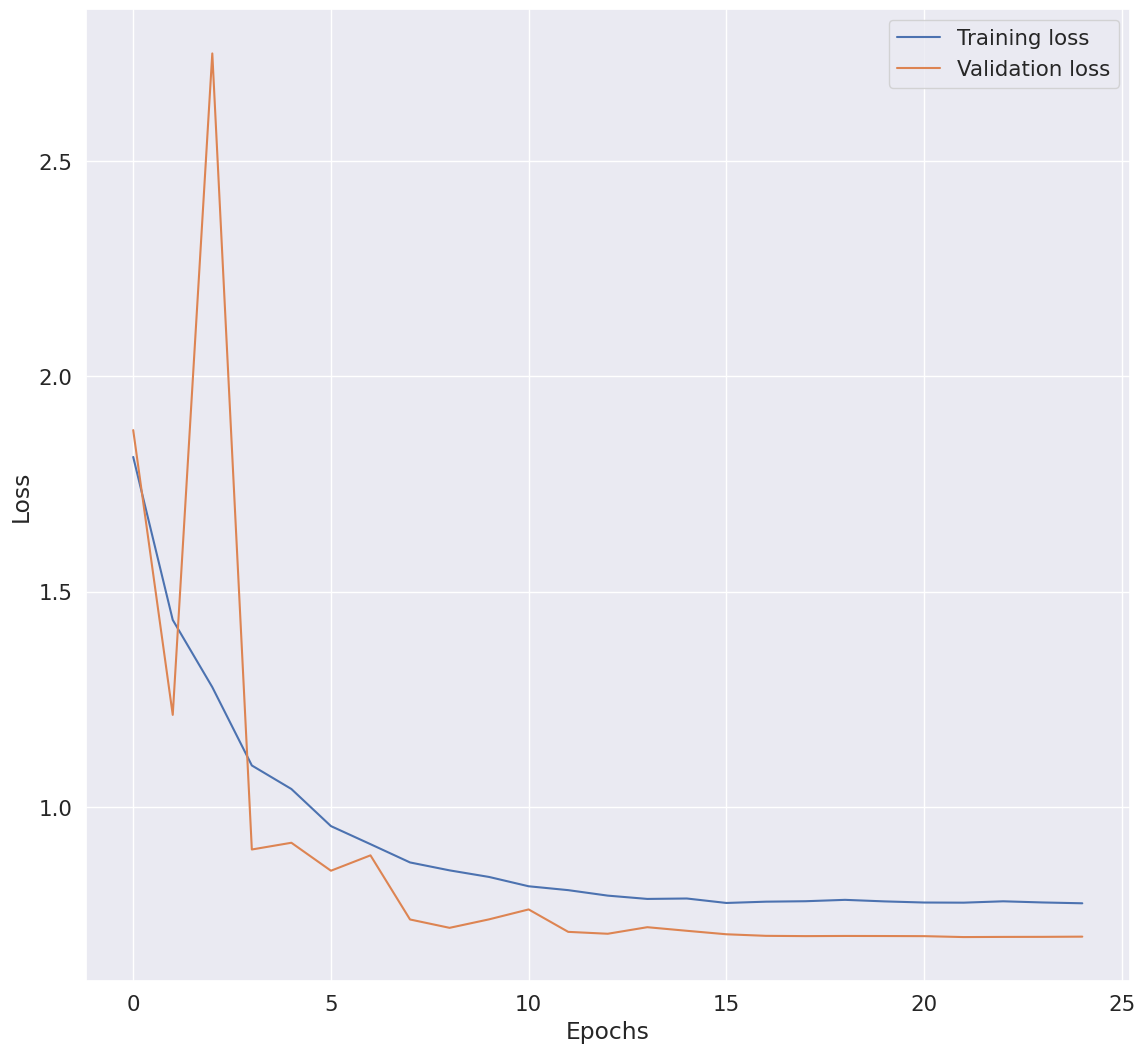

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7573 - loss: 0.7018
Test Accuracy: 0.7605168223381042, Precision: 0.7612386938321948, Recall: 0.7605168269230769, F1 Score: 0.7573708781794898
------------------------------------------------------------


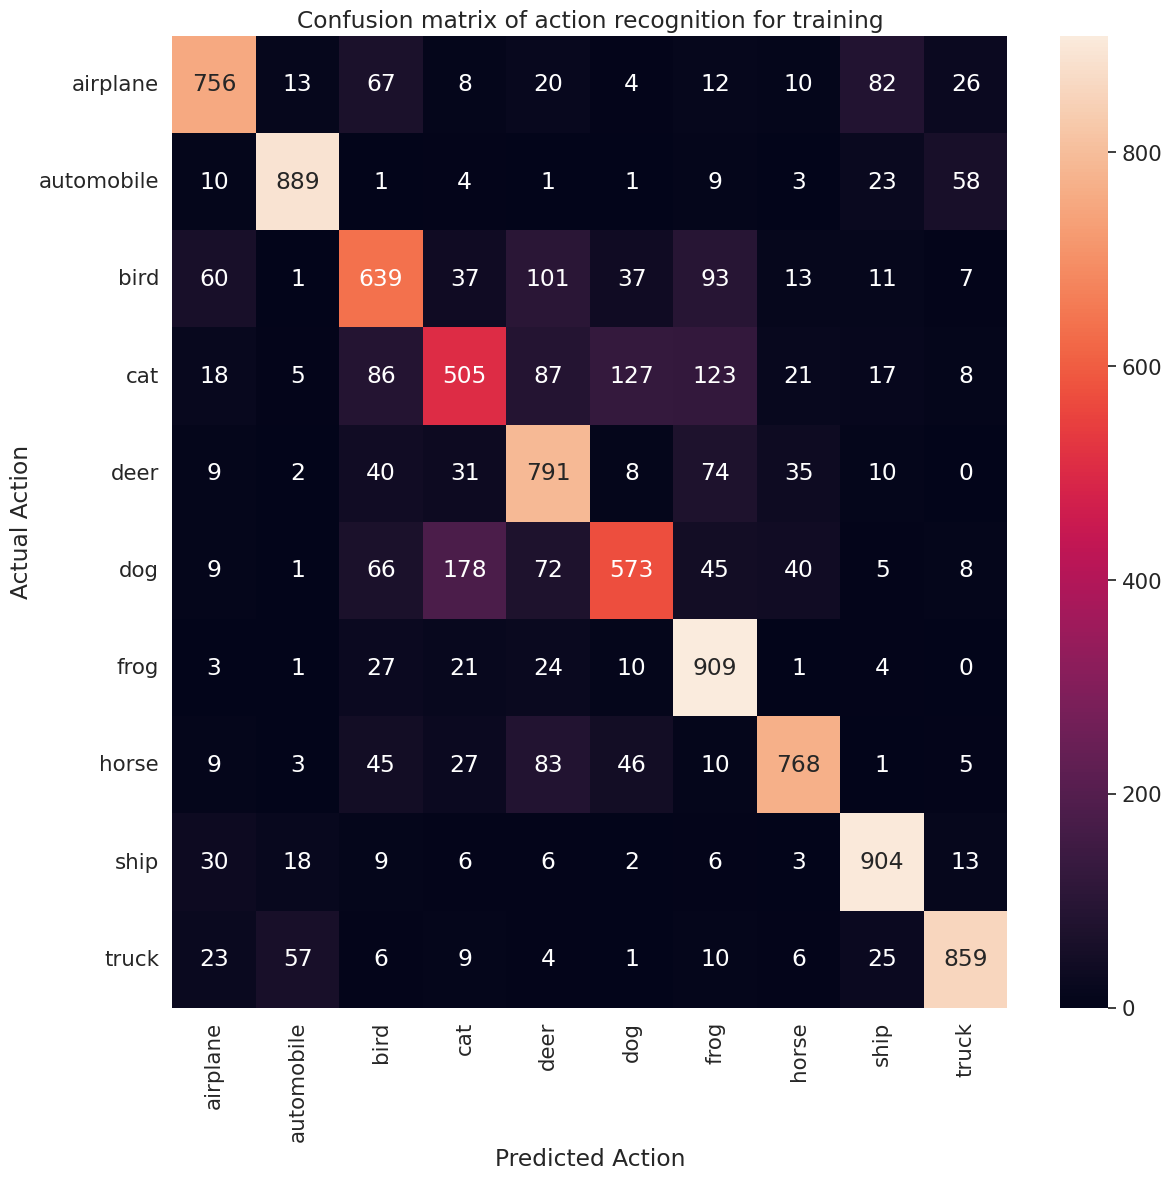

In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

Epoch 1/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 59s 6ms/step - accuracy: 0.3106 - loss: 2.1170 - val_accuracy: 0.4641 - val_loss: 1.5260 - learning_rate: 0.0010
Epoch 2/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.4848 - loss: 1.4286 - val_accuracy: 0.5522 - val_loss: 1.2360 - learning_rate: 0.0010
Epoch 3/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5533 - loss: 1.2678 - val_accuracy: 0.6220 - val_loss: 1.1218 - learning_rate: 0.0010
Epoch 4/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5972 - loss: 1.1539 - val_accuracy: 0.6478 - val_loss: 1.0462 - learning_rate: 0.0010
Epoch 5/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6294 - loss: 1.0724 - val_accuracy: 0.6824 - val_loss: 0.9211 - learning_rate: 0.0010
Epoch 6/30
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.6473 - loss: 1.0235 - val_accuracy: 0.6907 - val_loss: 0.8893 - learning_rate: 0.0010
Epoch 7/30
1559/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6651

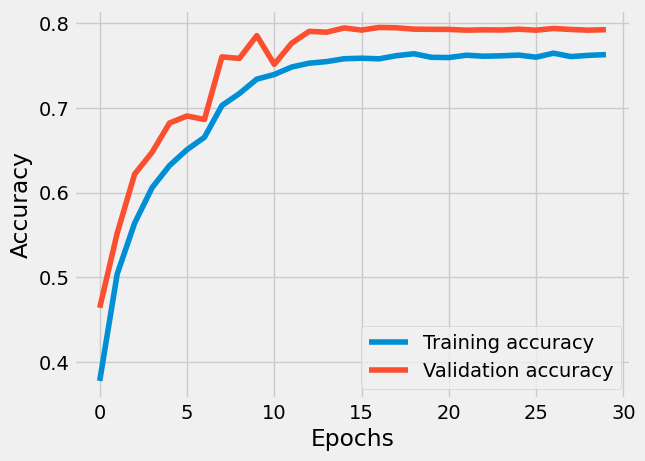

In [ ]:
history = model.fit(
    train_ds,
    validation_data= test_ds,
    epochs=30,
    callbacks=[reduce_lr]
)
plot_visualization(history)

### batch_size=32 > (64, 128) дають гірші результати ~~77%

# Dropout change

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

# Ініціалізація моделі
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.2))  # Dropout 20% для регуляризації


# Перший блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(64, (3, 3), padding='same'))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.25))  # Dropout 25% для регуляризації

# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(128, (3, 3), padding='same'))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Третій блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(256, (3, 3), padding='same'))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Збільшуємо Dropout для глибших шарів

# Фінальна частина: Flatten -> Повністю зв'язаний шар -> ReLU -> Dropout -> Класифікаційний шар
model.add(Flatten())  # Перетворюємо 2D дані на 1D
model.add(Dense(512))  # Повністю зв’язаний шар із 512 нейронами
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout для запобігання перенавчанню

# Вихідний класифікаційний шар (Softmax для багатокласової класифікації)
model.add(Dense(10))  # 10 класів (наприклад, CIFAR-10)
model.add(Activation('softmax'))  # Softmax для ймовірнісного виходу

#optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Перевіряємо структуру моделі
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_23 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_24 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_25 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Training model CNN


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_17 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_18 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_19 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.3062 - loss: 2.1028 - val_accuracy: 0.4618 - val_loss: 1.5473 - learning_rate: 0.0010
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4849 - loss: 1.4336 - val_accuracy: 0.5706 - val_loss: 1.2252 - learning_rate: 0.0010
Epoch 3/25
1242/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5466 - loss: 1.2736
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5466 - loss: 1.2734 - val_accuracy: 0.5492 - val_loss: 1.3371 - learning_rate: 0.0010
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6081 - loss: 1.1033 - val_accuracy: 0.6928 - val_loss: 0.8727 - learning_rate: 5.0000e-04
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.6408 - loss: 1.0202 - val_accuracy: 0.7034 - val_loss: 0.8536 - learning_rate: 5.0000e-04
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.

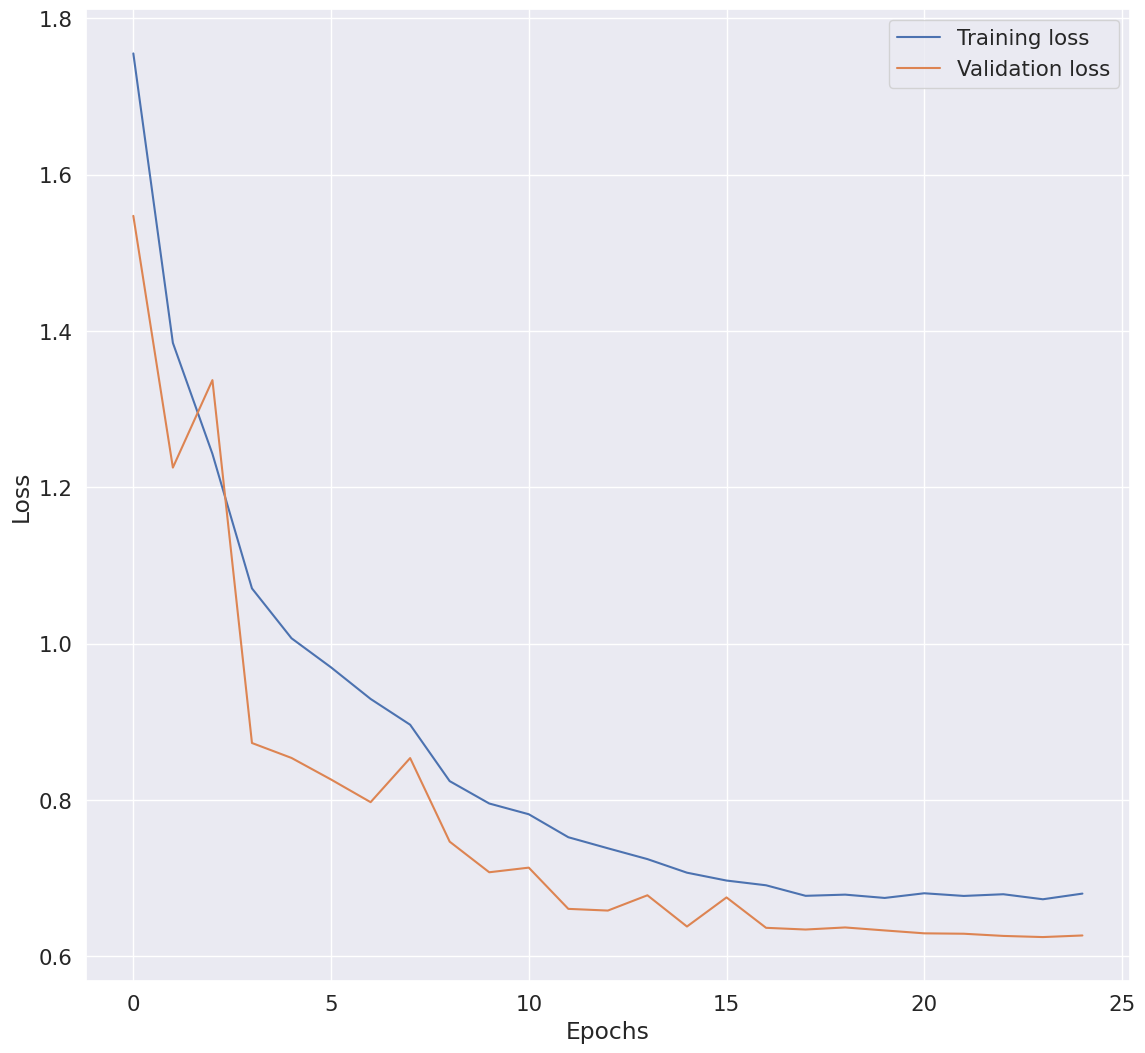

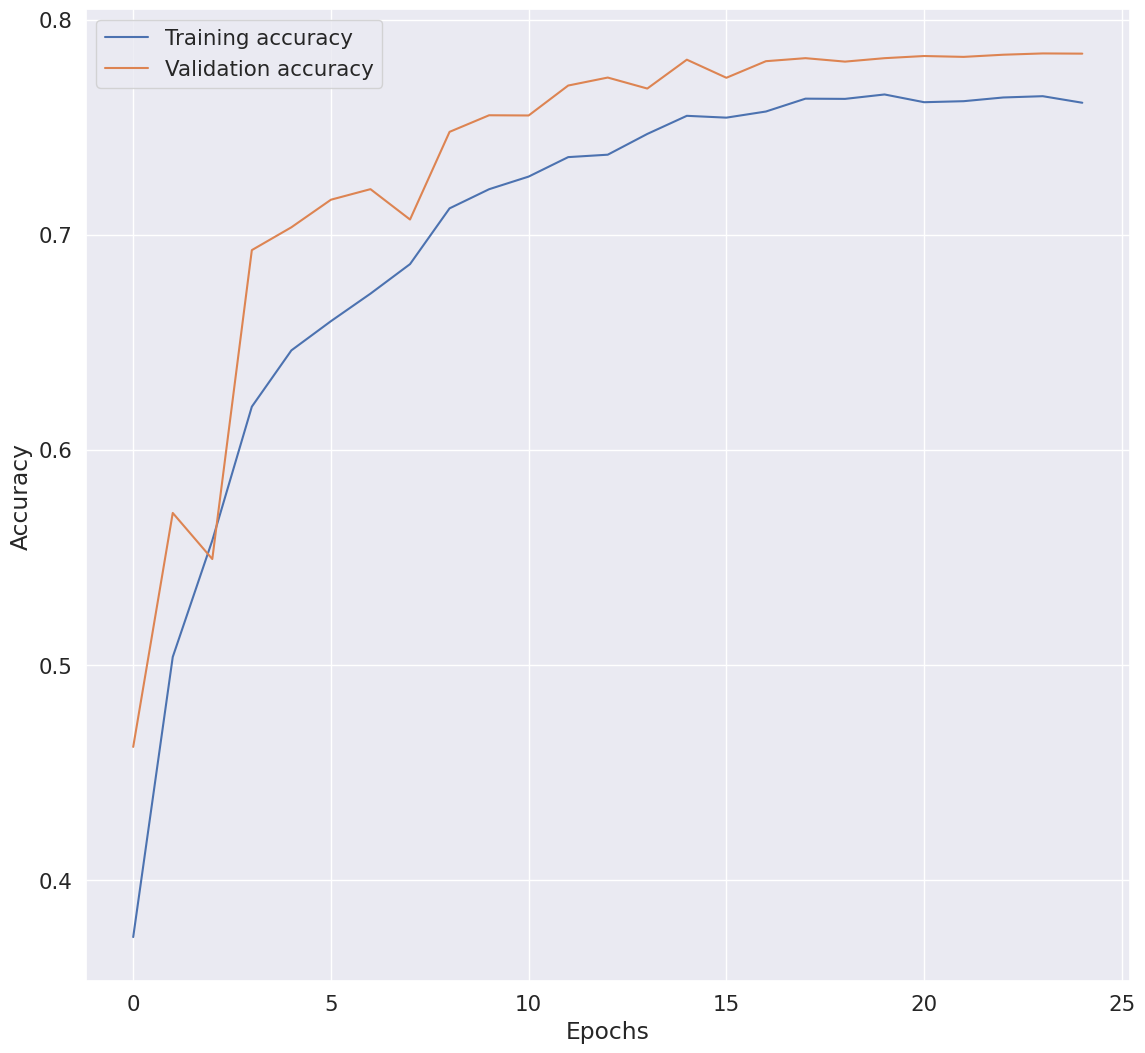

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7888 - loss: 0.6239
Test Accuracy: 0.7905648946762085, Precision: 0.7899564807516996, Recall: 0.7905649038461539, F1 Score: 0.7880702694787588
------------------------------------------------------------


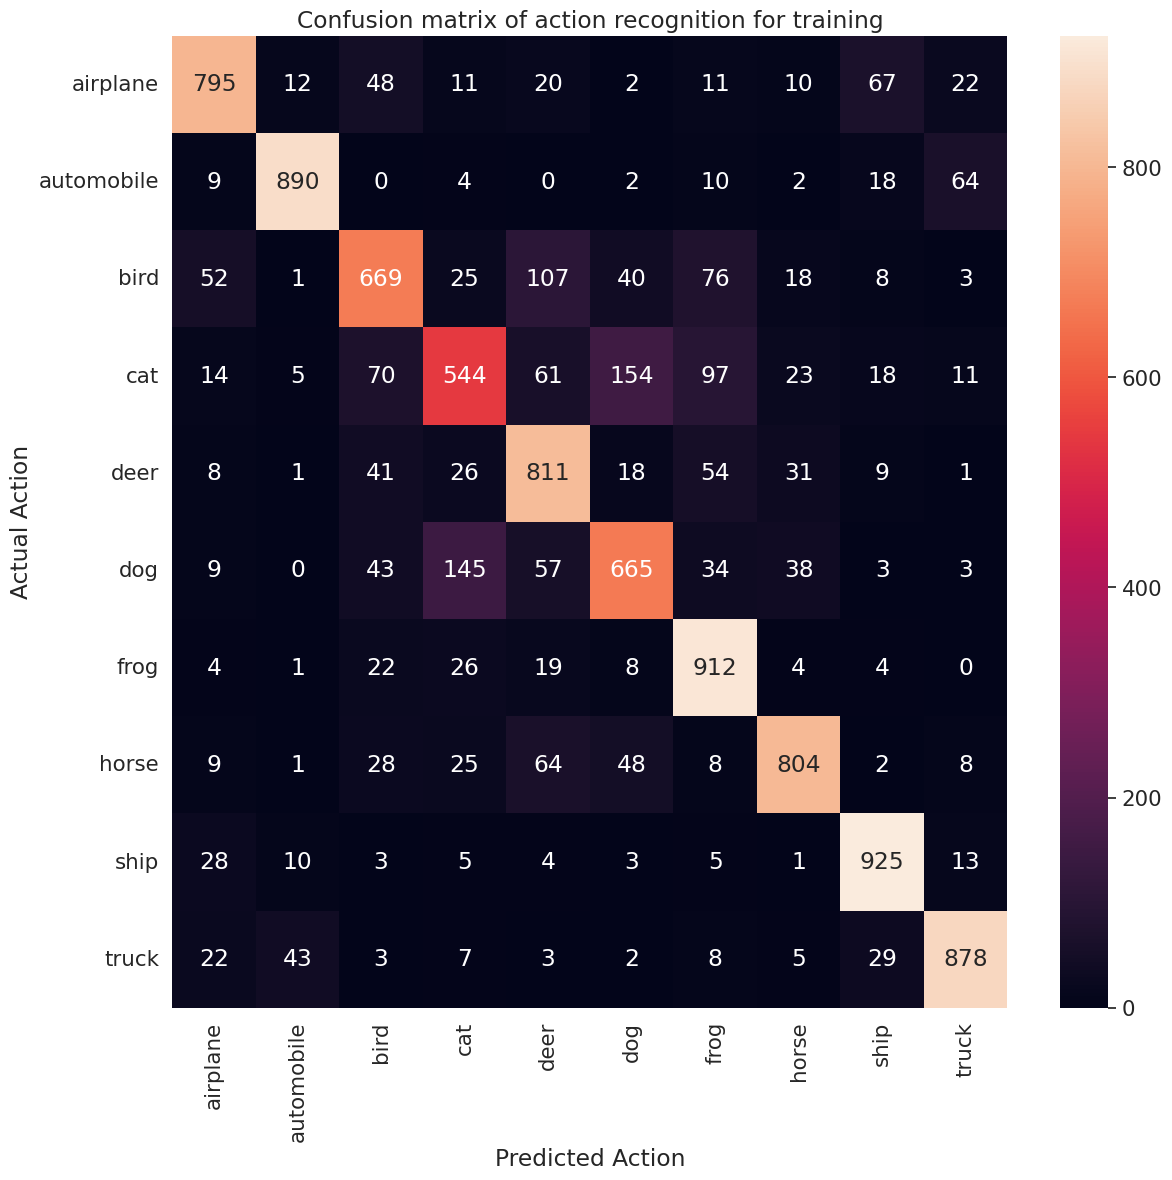

In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

Epoch 1/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.3207 - loss: 2.0480 - val_accuracy: 0.5055 - val_loss: 1.3695 - learning_rate: 0.0010
Epoch 2/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4991 - loss: 1.3973 - val_accuracy: 0.5280 - val_loss: 1.3504 - learning_rate: 0.0010
Epoch 3/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5723 - loss: 1.2115 - val_accuracy: 0.6095 - val_loss: 1.1210 - learning_rate: 0.0010
Epoch 4/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6161 - loss: 1.1032 - val_accuracy: 0.6976 - val_loss: 0.8739 - learning_rate: 0.0010
Epoch 5/25
1559/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6427 - loss: 1.0198
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6427 - loss: 1.0198 - val_accuracy: 0.6614 - val_loss: 1.0083 - learning_rate: 0.0010
Epoch 6/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6858 - l

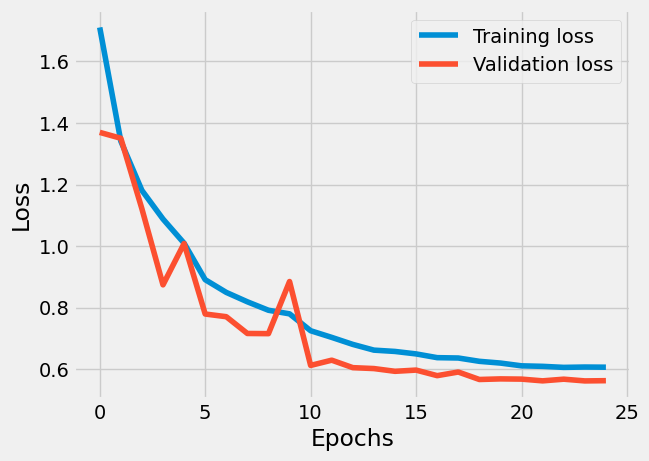

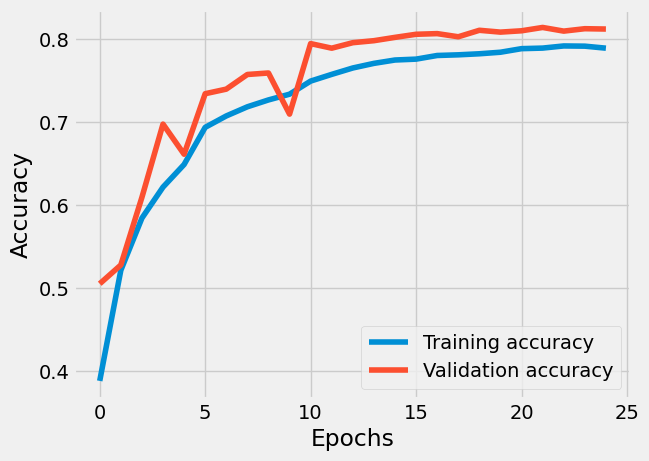

In [ ]:
history = model.fit(
    train_ds,
    validation_data= test_ds,
    epochs=25,
    callbacks=[reduce_lr]
)
plot_visualization(history)

### модель швидше навчається при плавному переході значень droupout - дає кращі показники , але графіки стали різкішими = спробувати додати регуляризауію

# kernel_initializer & kernel_regularizer

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
# Ініціалізація моделі
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.2))  # Dropout 25% для регуляризації


# Перший блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.25))  # Dropout 25% для регуляризації

# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Третій блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Збільшуємо Dropout для глибших шарів

# Фінальна частина: Flatten -> Повністю зв'язаний шар -> ReLU -> Dropout -> Класифікаційний шар
model.add(Flatten())  # Перетворюємо 2D дані на 1D
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Повністю зв’язаний шар із 512 нейронами
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout для запобігання перенавчанню

# Вихідний класифікаційний шар (Softmax для багатокласової класифікації)
model.add(Dense(10))  # 10 класів (наприклад, CIFAR-10)
model.add(Activation('softmax'))  # Softmax для ймовірнісного виходу

#optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Перевіряємо структуру моделі
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Training model CNN


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_29 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_30 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_31 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_32 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.2746 - loss: 4.1687 - val_accuracy: 0.4718 - val_loss: 2.6324 - learning_rate: 0.0010
Epoch 2/25
1246/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4481 - loss: 2.5435
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.4483 - loss: 2.5428 - val_accuracy: 0.4665 - val_loss: 2.4734 - learning_rate: 0.0010
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5553 - loss: 1.9351 - val_accuracy: 0.6642 - val_loss: 1.5362 - learning_rate: 5.0000e-04
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6049 - loss: 1.6701 - val_accuracy: 0.6790 - val_loss: 1.4479 - learning_rate: 5.0000e-04
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6399 - loss: 1.5532 - val_accuracy: 0.6863 - val_loss: 1.3953 - learning_rate: 5.0000e-04
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accurac

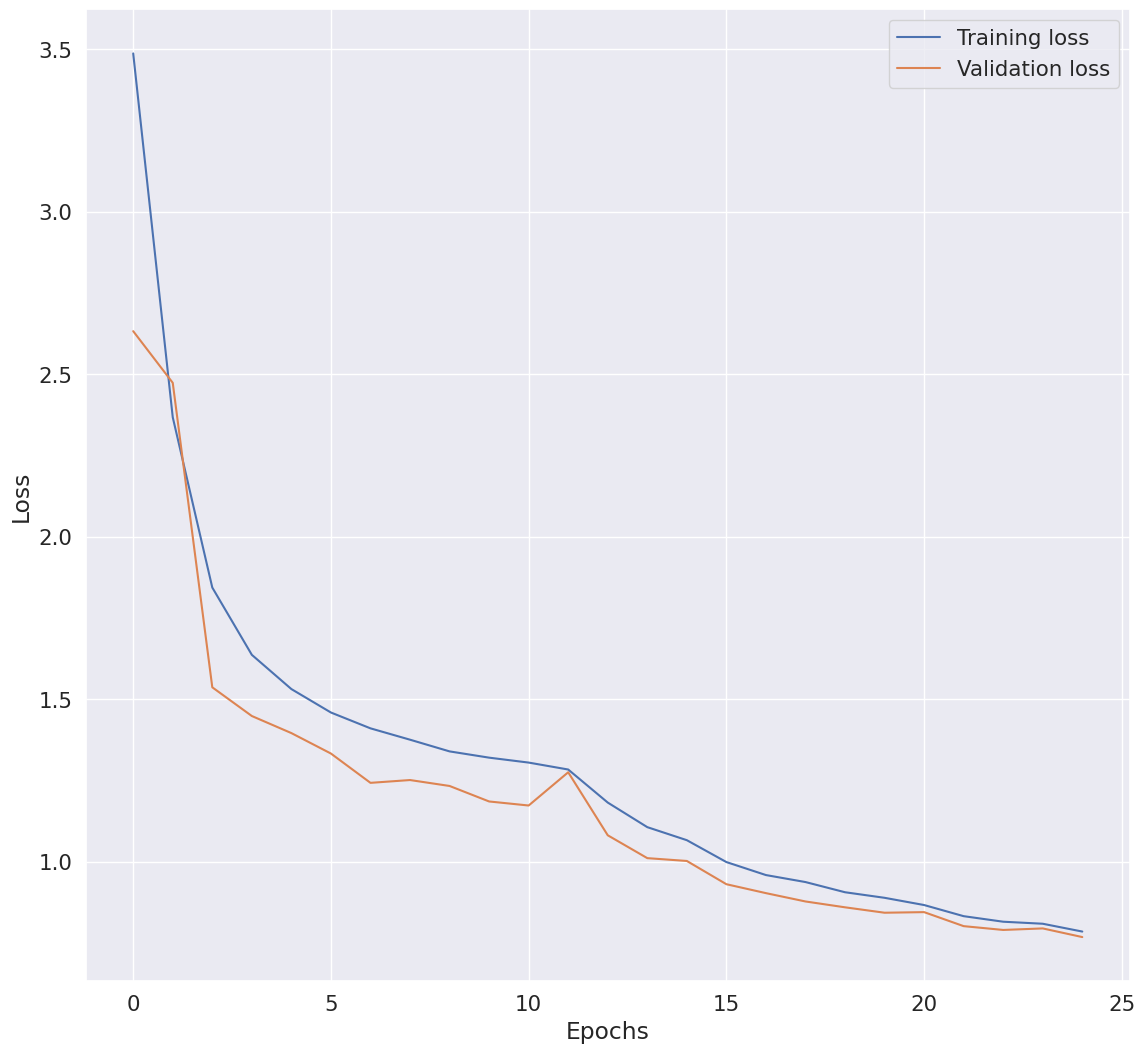

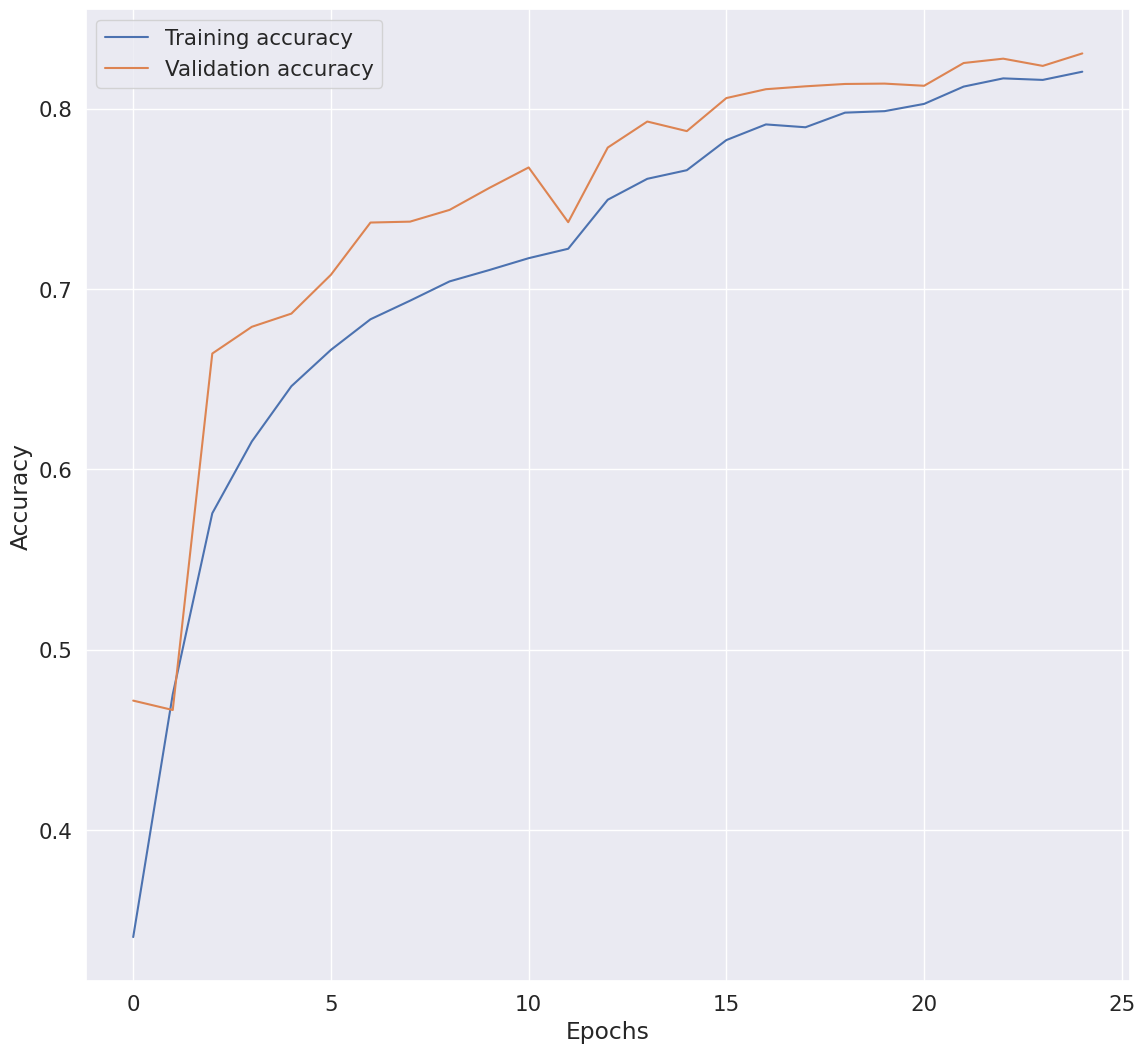

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8270 - loss: 0.7804
Test Accuracy: 0.8277243375778198, Precision: 0.8286403960310722, Recall: 0.8277243589743589, F1 Score: 0.8264008874531902
------------------------------------------------------------


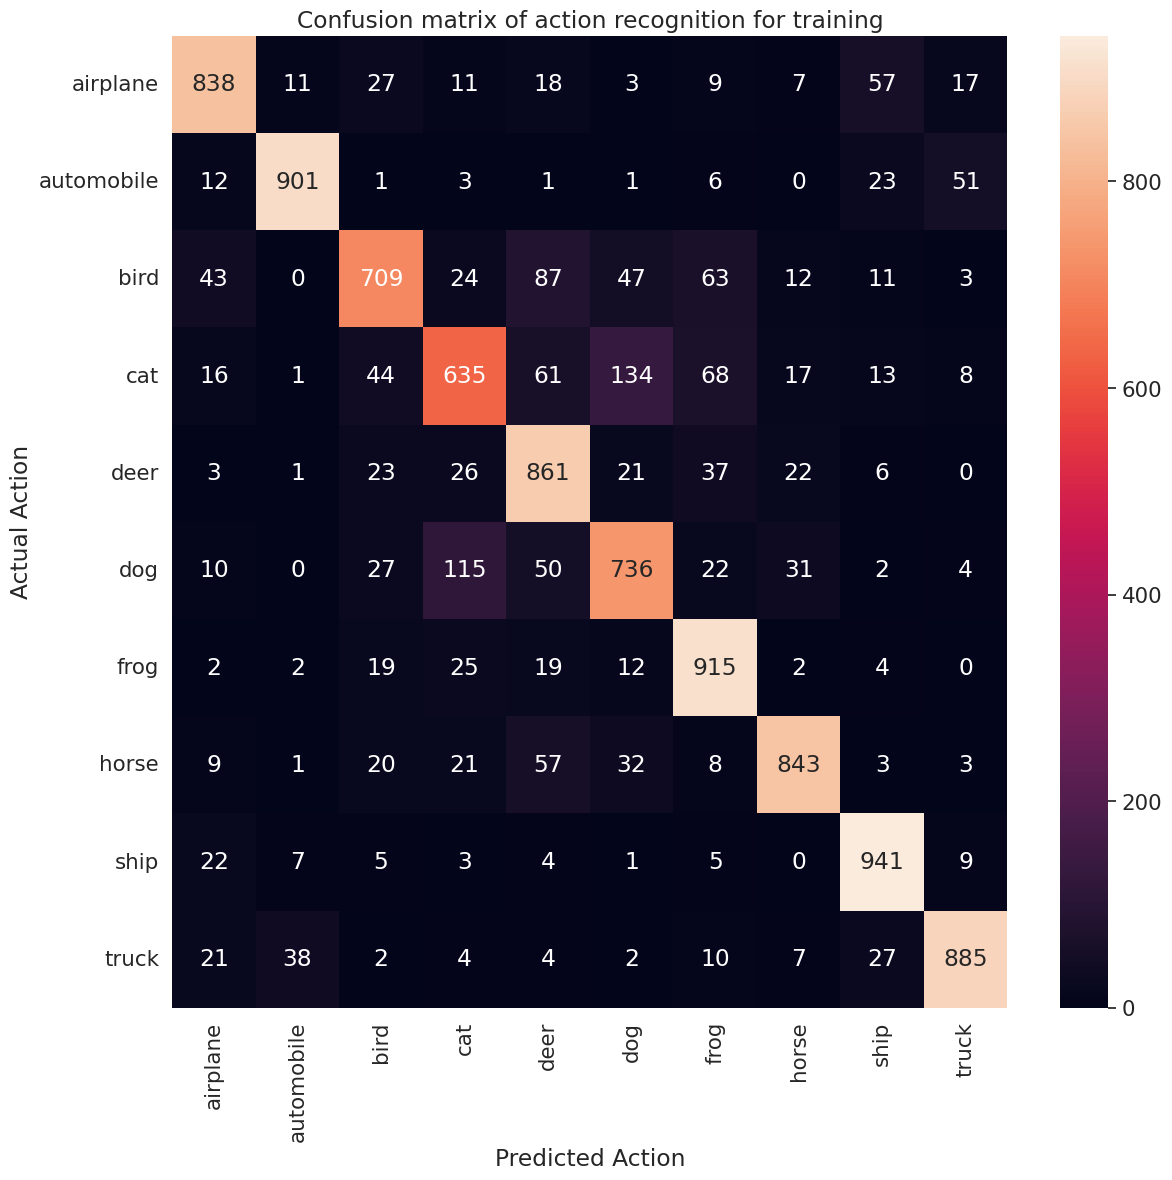

In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

Epoch 1/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - accuracy: 0.2987 - loss: 3.9511 - val_accuracy: 0.4274 - val_loss: 2.7677 - learning_rate: 0.0010
Epoch 2/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4965 - loss: 2.3013 - val_accuracy: 0.5800 - val_loss: 1.8366 - learning_rate: 0.0010
Epoch 3/25
1553/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5726 - loss: 1.8982
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5726 - loss: 1.8980 - val_accuracy: 0.5766 - val_loss: 1.8665 - learning_rate: 0.0010
Epoch 4/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6451 - loss: 1.6434 - val_accuracy: 0.7169 - val_loss: 1.3406 - learning_rate: 5.0000e-04
Epoch 5/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6775 - loss: 1.4548 - val_accuracy: 0.7206 - val_loss: 1.3020 - learning_rate: 5.0000e-04
Epoch 6/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 

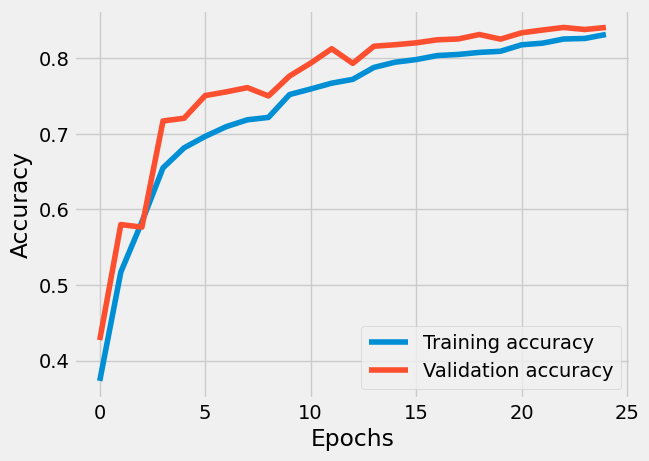

In [ ]:
history = model.fit(
    train_ds,
    validation_data= test_ds,
    epochs=25,
    callbacks=[reduce_lr]
)
plot_visualization(history)

### модель краще навчилася при додаванні kernel_initializer='he_uniform', kernel_regularizer=l2(0.001) - дає кращі показники 84%, графіки стали плавнішими , але високий показник loss функції = 0.7 на порядок вищий попереднім результатам = збільшити рівень регуляризації

# kernel_regularizer 0.0001

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
# Ініціалізація моделі
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.2))  # Dropout 25% для регуляризації


# Перший блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.25))  # Dropout 25% для регуляризації

# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Третій блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Збільшуємо Dropout для глибших шарів

# Фінальна частина: Flatten -> Повністю зв'язаний шар -> ReLU -> Dropout -> Класифікаційний шар
model.add(Flatten())  # Перетворюємо 2D дані на 1D
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.0001)))  # Повністю зв’язаний шар із 512 нейронами
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout для запобігання перенавчанню

# Вихідний класифікаційний шар (Softmax для багатокласової класифікації)
model.add(Dense(10))  # 10 класів (наприклад, CIFAR-10)
model.add(Activation('softmax'))  # Softmax для ймовірнісного виходу

#optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Перевіряємо структуру моделі
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

Training model CNN


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_35 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_36 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_37 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_38 (Activation)           │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 920,266 (3.51 MB)

 Trainable params: 919,306 (3.51 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.2796 - loss: 2.4816 - val_accuracy: 0.4290 - val_loss: 2.0887 - learning_rate: 0.0010
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.4398 - loss: 1.7320 - val_accuracy: 0.5228 - val_loss: 1.6110 - learning_rate: 0.0010
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.5133 - loss: 1.5720 - val_accuracy: 0.5920 - val_loss: 1.4070 - learning_rate: 0.0010
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.5604 - loss: 1.4580 - val_accuracy: 0.6498 - val_loss: 1.2408 - learning_rate: 0.0010
Epoch 5/25
1237/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6003 - loss: 1.3853
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6004 - loss: 1.3852 - val_accuracy: 0.6387 - val_loss: 1.3327 - learning_rate: 0.0010
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6418 

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7767 - loss: 0.8530
Test Accuracy: 0.7790464758872986, Precision: 0.7814798854884254, Recall: 0.7790464743589743, F1 Score: 0.7762057027662171
------------------------------------------------------------


Epoch 1/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.2919 - loss: 2.4007 - val_accuracy: 0.5136 - val_loss: 1.5741 - learning_rate: 0.0010
Epoch 2/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.4811 - loss: 1.6408 - val_accuracy: 0.5684 - val_loss: 1.4500 - learning_rate: 0.0010
Epoch 3/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.5563 - loss: 1.4704 - val_accuracy: 0.6415 - val_loss: 1.2556 - learning_rate: 0.0010
Epoch 4/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.5992 - loss: 1.3859 - val_accuracy: 0.6858 - val_loss: 1.1583 - learning_rate: 0.0010
Epoch 5/25
1555/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6299 - loss: 1.3152
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.6300 - loss: 1.3151 - val_accuracy: 0.6709 - val_loss: 1.2854 - learning_rate: 0.0010
Epoch 6/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6773 - 

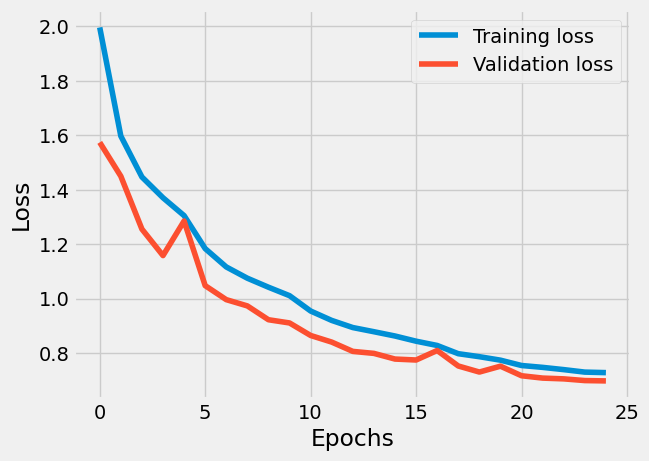

In [ ]:
history = model.fit(
    train_ds,
    validation_data= test_ds,
    epochs=25,
    callbacks=[reduce_lr]
)
plot_visualization(history)

### плавніший графік при kernel_regularizer=l2(0.0001 і 0.01) але гірша точність, loss не впав (0.7) = результати не покращились

# change architection on model with AveragePooling2D and 2 Conv2D(512) 32-32-64-64-128-128-256-256-512-512
Adam(0.001, beta_1=0.9, beta_2=0.999)
accuracy: 0.9067 - loss: 0.5073 - val_accuracy: 0.8816 - val_loss: 0.6066 - learning_rate: 7.8125e-06

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, AveragePooling2D
from keras.regularizers import l2
# Ініціалізація моделі
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.2))  # Dropout 20% для регуляризації


# перший блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Збільшуємо Dropout для глибших шарів


# третій блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Збільшуємо Dropout для глибших шарів


# четвертий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Збільшуємо Dropout для глибших шарів


# четвертий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Збільшуємо Dropout для глибших шарів


# Фінальна частина: Flatten -> Повністю зв'язаний шар -> ReLU -> Dropout -> Класифікаційний шар
model.add(Flatten())  # Перетворюємо 2D дані на 1D
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Повністю зв’язаний шар із 512 нейронами
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout для запобігання перенавчанню

# Вихідний класифікаційний шар (Softmax для багатокласової класифікації)
model.add(Dense(10))  # 10 класів (наприклад, CIFAR-10)
model.add(Activation('softmax'))  # Softmax для ймовірнісного виходу

optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Перевіряємо структуру моделі
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_41 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_44 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,987,946 (19.03 MB)

 Trainable params: 4,983,978 (19.01 MB)

 Non-trainable params: 3,968 (15.50 KB)

Training model CNN


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_41 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_42 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_43 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_44 (Activation)           │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_45 (Activation)           │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,987,946 (19.03 MB)

 Trainable params: 4,983,978 (19.01 MB)

 Non-trainable params: 3,968 (15.50 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.2888 - loss: 6.9852 - val_accuracy: 0.4890 - val_loss: 3.8086 - learning_rate: 0.0010
Epoch 2/25
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4963 - loss: 3.3520
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4964 - loss: 3.3513 - val_accuracy: 0.4237 - val_loss: 2.7489 - learning_rate: 0.0010
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.6093 - loss: 2.0084 - val_accuracy: 0.6138 - val_loss: 1.8090 - learning_rate: 5.0000e-04
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6502 - loss: 1.6881 - val_accuracy: 0.6759 - val_loss: 1.5618 - learning_rate: 5.0000e-04
Epoch 5/25
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6762 - loss: 1.5800
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - ac

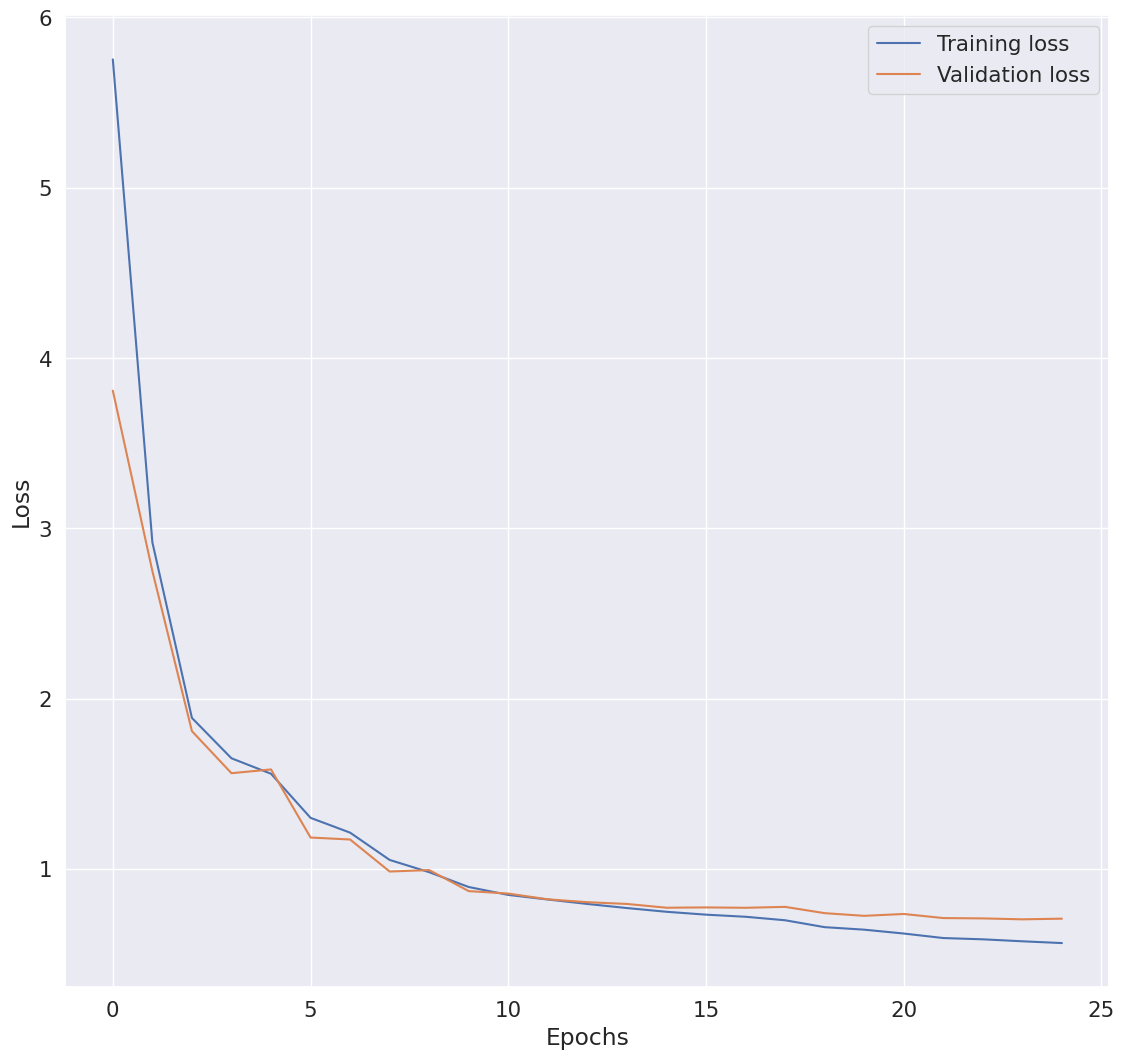

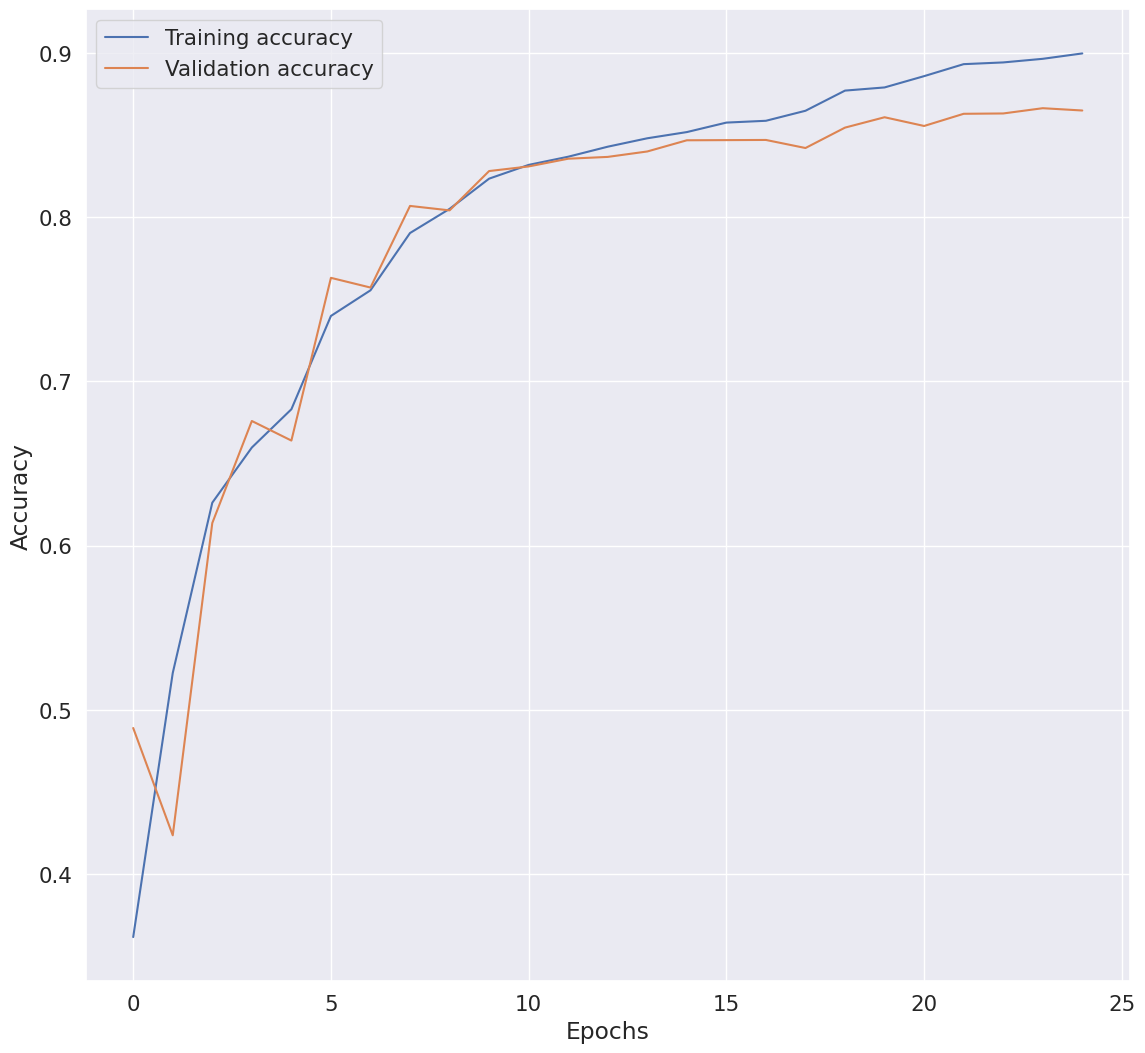

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8653 - loss: 0.7130
Test Accuracy: 0.8627804517745972, Precision: 0.8622986296300785, Recall: 0.8627804487179487, F1 Score: 0.8618493002817388
------------------------------------------------------------


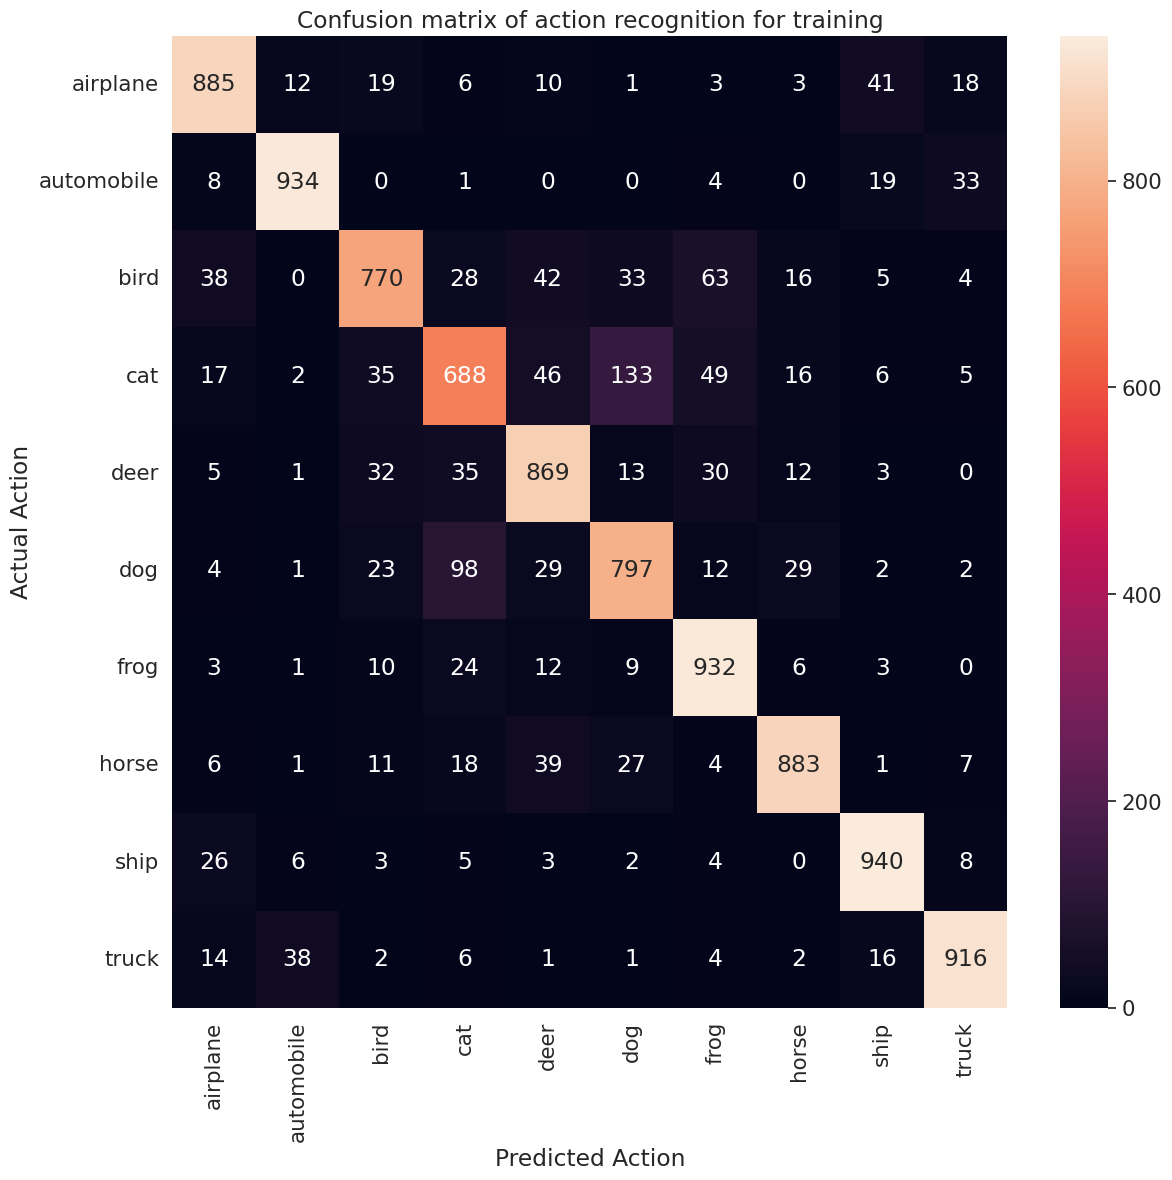

In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

Epoch 1/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - accuracy: 0.2997 - loss: 6.7282 - val_accuracy: 0.4807 - val_loss: 3.3644 - learning_rate: 0.0010
Epoch 2/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.5279 - loss: 2.8063 - val_accuracy: 0.6336 - val_loss: 1.8389 - learning_rate: 0.0010
Epoch 3/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6026 - loss: 1.9367
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.6026 - loss: 1.9367 - val_accuracy: 0.6218 - val_loss: 1.7707 - learning_rate: 0.0010
Epoch 4/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6769 - loss: 1.5858 - val_accuracy: 0.7063 - val_loss: 1.4302 - learning_rate: 5.0000e-04
Epoch 5/25
1561/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7064 - loss: 1.4318
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accura

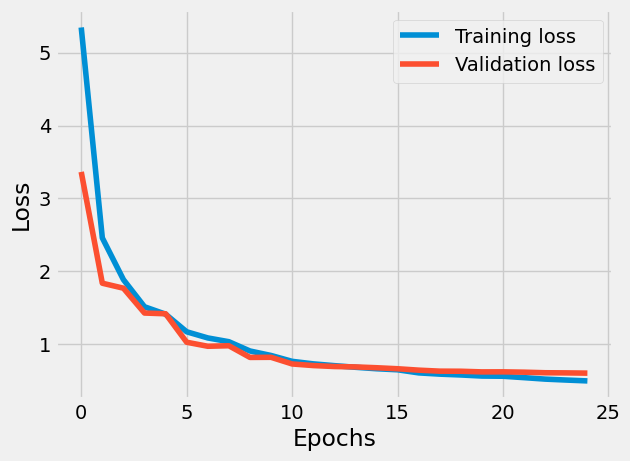

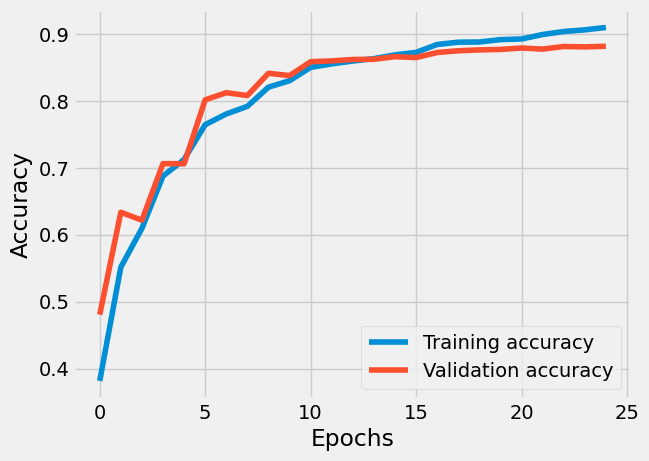

In [ ]:
history = model.fit(
    train_ds,
    validation_data= test_ds,
    epochs=25,
    callbacks=[reduce_lr]
)
plot_visualization(history)

### точність гірша accuracy: 0.9121 - loss: 0.5247 - val_accuracy: 0.8895 - val_loss: 0.6075 - learning_rate: 3.1250e-05 але перенавчання починається аж на 16 і дальше епосі

# THE BEAST MODEL: change architection on model
accuracy: 0.9598 - loss: 0.4219 - val_accuracy: 0.9027 - val_loss: 0.6286 - learning_rate: 1.5625e-05

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
# Ініціалізація моделі
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.2))  # Dropout 25% для регуляризації


# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Збільшуємо Dropout для глибших шарів


# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Збільшуємо Dropout для глибших шарів

# Фінальна частина: Flatten -> Повністю зв'язаний шар -> ReLU -> Dropout -> Класифікаційний шар
model.add(Flatten())  # Перетворюємо 2D дані на 1D
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Повністю зв’язаний шар із 512 нейронами
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout для запобігання перенавчанню

# Вихідний класифікаційний шар (Softmax для багатокласової класифікації)
model.add(Dense(10))  # 10 класів (наприклад, CIFAR-10)
model.add(Activation('softmax'))  # Softmax для ймовірнісного виходу

#optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Перевіряємо структуру моделі
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_53 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_54 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_55 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_57 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,232,330 (12.33 MB)

 Trainable params: 3,230,602 (12.32 MB)

 Non-trainable params: 1,728 (6.75 KB)

Training model CNN


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_53 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_54 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_55 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_40               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_56 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_41               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_57 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_42               │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 3,232,330 (12.33 MB)

 Trainable params: 3,230,602 (12.32 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.3254 - loss: 4.7924 - val_accuracy: 0.4402 - val_loss: 3.2066 - learning_rate: 0.0010
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5418 - loss: 2.6660 - val_accuracy: 0.5810 - val_loss: 2.1689 - learning_rate: 0.0010
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6187 - loss: 2.0409 - val_accuracy: 0.6417 - val_loss: 1.9116 - learning_rate: 0.0010
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6599 - loss: 1.9156 - val_accuracy: 0.6807 - val_loss: 1.8638 - learning_rate: 0.0010
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6838 - loss: 1.8810 - val_accuracy: 0.7121 - val_loss: 1.7749 - learning_rate: 0.0010
Epoch 6/25
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7009 - loss: 1.8062
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy

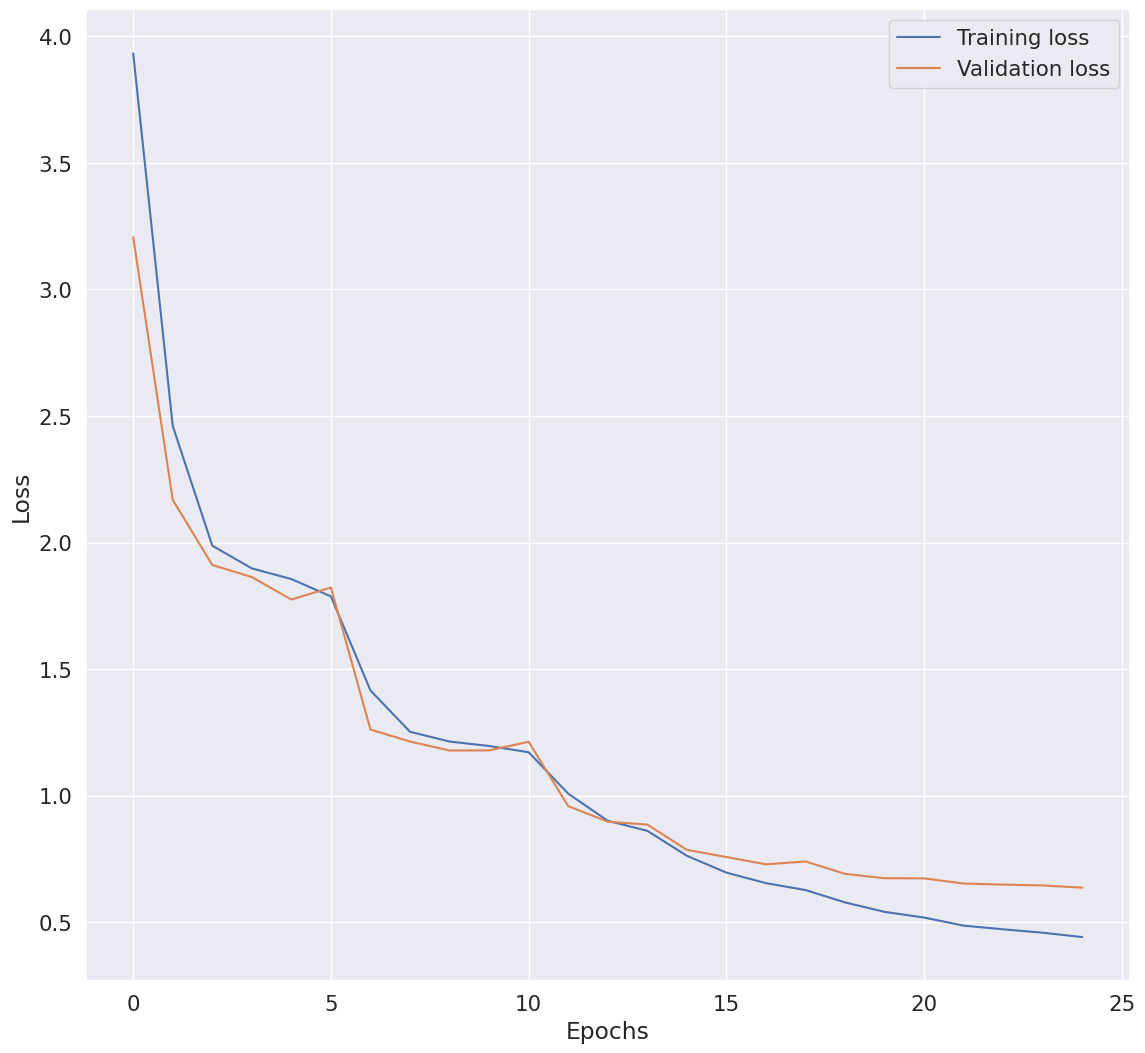

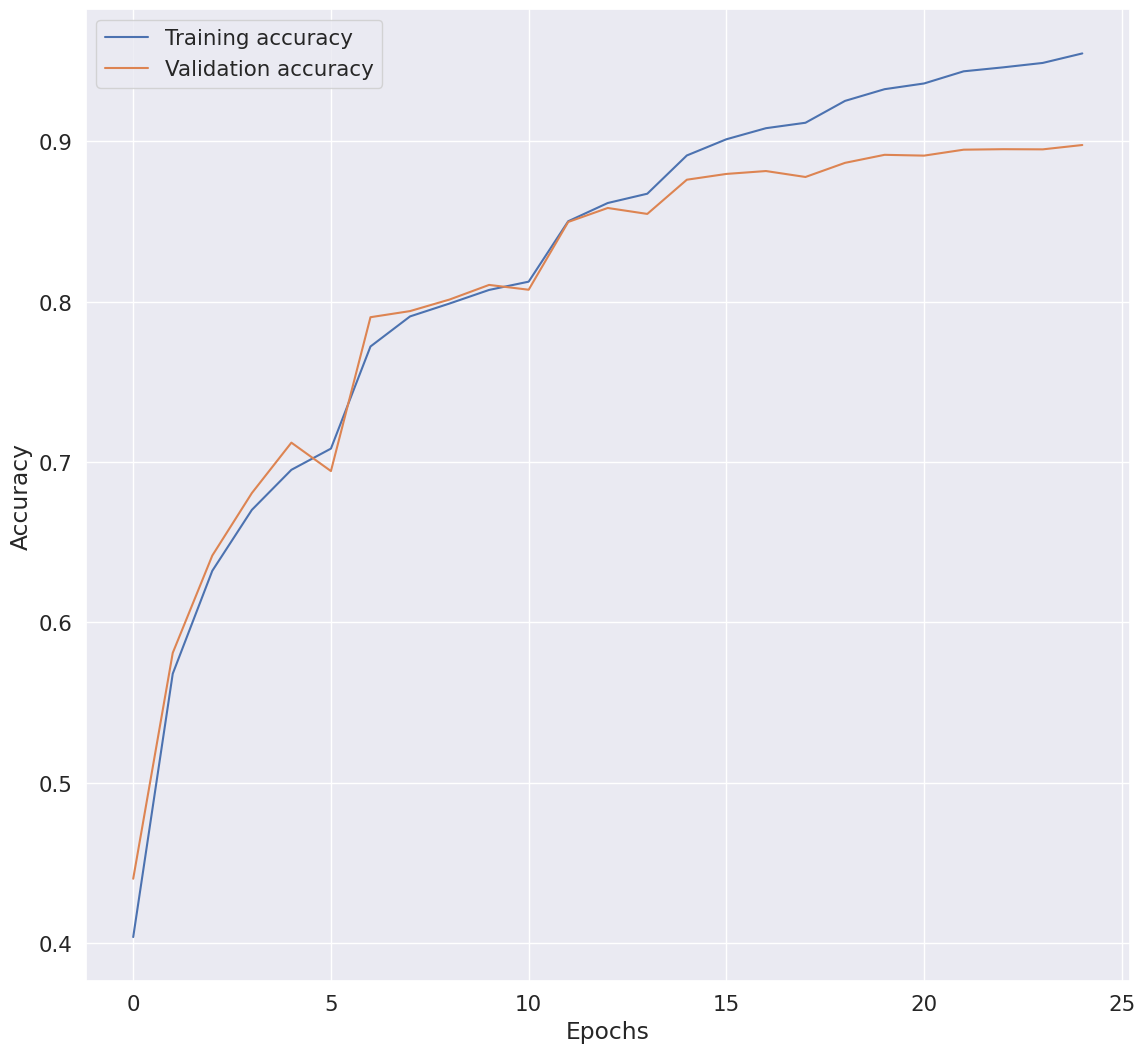

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8972 - loss: 0.6428
Test Accuracy: 0.8965344429016113, Precision: 0.8964195623083366, Recall: 0.8965344551282052, F1 Score: 0.8961556023948878
------------------------------------------------------------


In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

Epoch 1/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - accuracy: 0.3348 - loss: 4.5867 - val_accuracy: 0.5691 - val_loss: 2.5334 - learning_rate: 0.0010
Epoch 2/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.5753 - loss: 2.3957 - val_accuracy: 0.6872 - val_loss: 1.7791 - learning_rate: 0.0010
Epoch 3/25
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6490 - loss: 1.9379
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6490 - loss: 1.9379 - val_accuracy: 0.6789 - val_loss: 1.8630 - learning_rate: 0.0010
Epoch 4/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7269 - loss: 1.6232 - val_accuracy: 0.7810 - val_loss: 1.3497 - learning_rate: 5.0000e-04
Epoch 5/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7616 - loss: 1.4069 - val_accuracy: 0.7861 - val_loss: 1.3149 - learning_rate: 5.0000e-04
Epoch 6/25
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - 

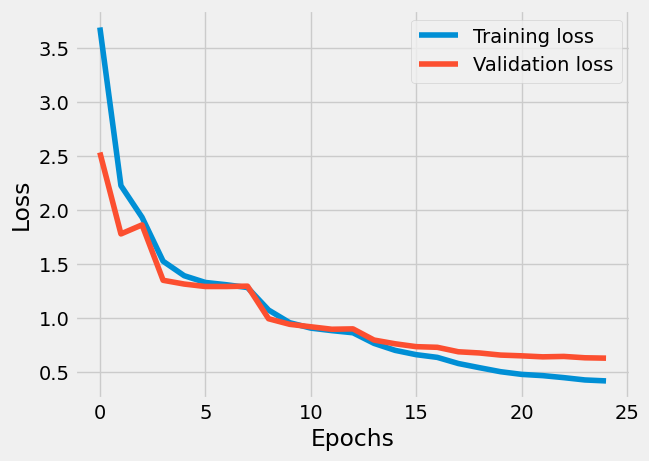

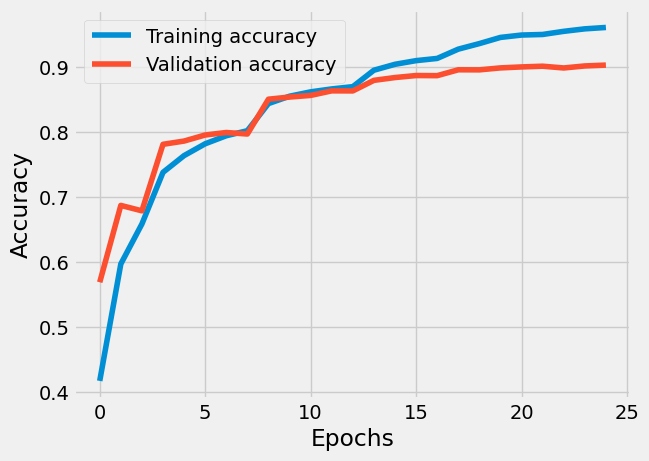

In [ ]:
history = model.fit(
    train_ds,
    validation_data= test_ds,
    epochs=25,
    callbacks=[reduce_lr]
)
plot_visualization(history)

### модель краще навчилася при додаванні kernel_initializer='he_uniform', kernel_regularizer=l2(0.001) - дає кращі показники 84%, графіки стали плавнішими , але високий показник loss функції = 0.7 на порядок вищий попереднім результатам = збільшити рівень регуляризації

# change architection on model **AveragePooling2D** 32-64-128-128-256-256
accuracy: 0.9214 - loss: 0.5508 - val_accuracy: 0.8909 - val_loss: 0.6578 - learning_rate: 1.1765e-04
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                          patience=1,
                          verbose=1,
                          factor=0.7,
                          min_lr=1e-6)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2
# Ініціалізація моделі
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3), kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки

model.add(Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 64 фільтри 3x3
model.add(Activation('relu'))  # Активаційний шар
model.add(BatchNormalization())  # Нормалізація після згортки
model.add(MaxPooling2D(pool_size=(2, 2)))  # Зменшення розмірності через Max Pooling
model.add(Dropout(0.2))  # Dropout 25% для регуляризації


# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))  # Збільшуємо Dropout для глибших шарів


# Другий блок: Згортка -> ReLU -> Batch Normalization -> Max Pooling -> Dropout
model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 128 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Згортка 256 фільтрів
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))  # Збільшуємо Dropout для глибших шарів

# Фінальна частина: Flatten -> Повністю зв'язаний шар -> ReLU -> Dropout -> Класифікаційний шар
model.add(Flatten())  # Перетворюємо 2D дані на 1D
model.add(Dense(512, kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))  # Повністю зв’язаний шар із 512 нейронами
model.add(Activation('relu'))
model.add(Dropout(0.5))  # Dropout для запобігання перенавчанню

# Вихідний класифікаційний шар (Softmax для багатокласової класифікації)
model.add(Dense(10))  # 10 класів (наприклад, CIFAR-10)
model.add(Activation('softmax'))  # Softmax для ймовірнісного виходу

#optimizer = Adam(0.001, beta_1=0.9, beta_2=0.999)
# Компіляція моделі
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Перевіряємо структуру моделі
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_61 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_62 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_63 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_64 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 8, 8, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_65 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 8, 8, 256)           │           1,0

 Total params: 3,232,330 (12.33 MB)

 Trainable params: 3,230,602 (12.32 MB)

 Non-trainable params: 1,728 (6.75 KB)

Training model CNN


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_61 (Activation)           │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_62 (Activation)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_63 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_64 (Activation)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 8, 8, 128)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_65 (Activation)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 8, 8, 256)           │           1,0

 Total params: 3,232,330 (12.33 MB)

 Trainable params: 3,230,602 (12.32 MB)

 Non-trainable params: 1,728 (6.75 KB)

Epoch 1/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 12ms/step - accuracy: 0.3927 - loss: 4.5092 - val_accuracy: 0.5325 - val_loss: 3.0222 - learning_rate: 0.0010
Epoch 2/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6082 - loss: 2.5514 - val_accuracy: 0.6366 - val_loss: 2.1254 - learning_rate: 0.0010
Epoch 3/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.6595 - loss: 2.0762 - val_accuracy: 0.6641 - val_loss: 2.0434 - learning_rate: 0.0010
Epoch 4/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.6945 - loss: 1.9833 - val_accuracy: 0.7140 - val_loss: 1.9244 - learning_rate: 0.0010
Epoch 5/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7087 - loss: 1.9157
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7087 - loss: 1.9157 - val_accuracy: 0.6997 - val_loss: 1.8620 - learning_rate: 0.0010
Epoch 6/25
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy

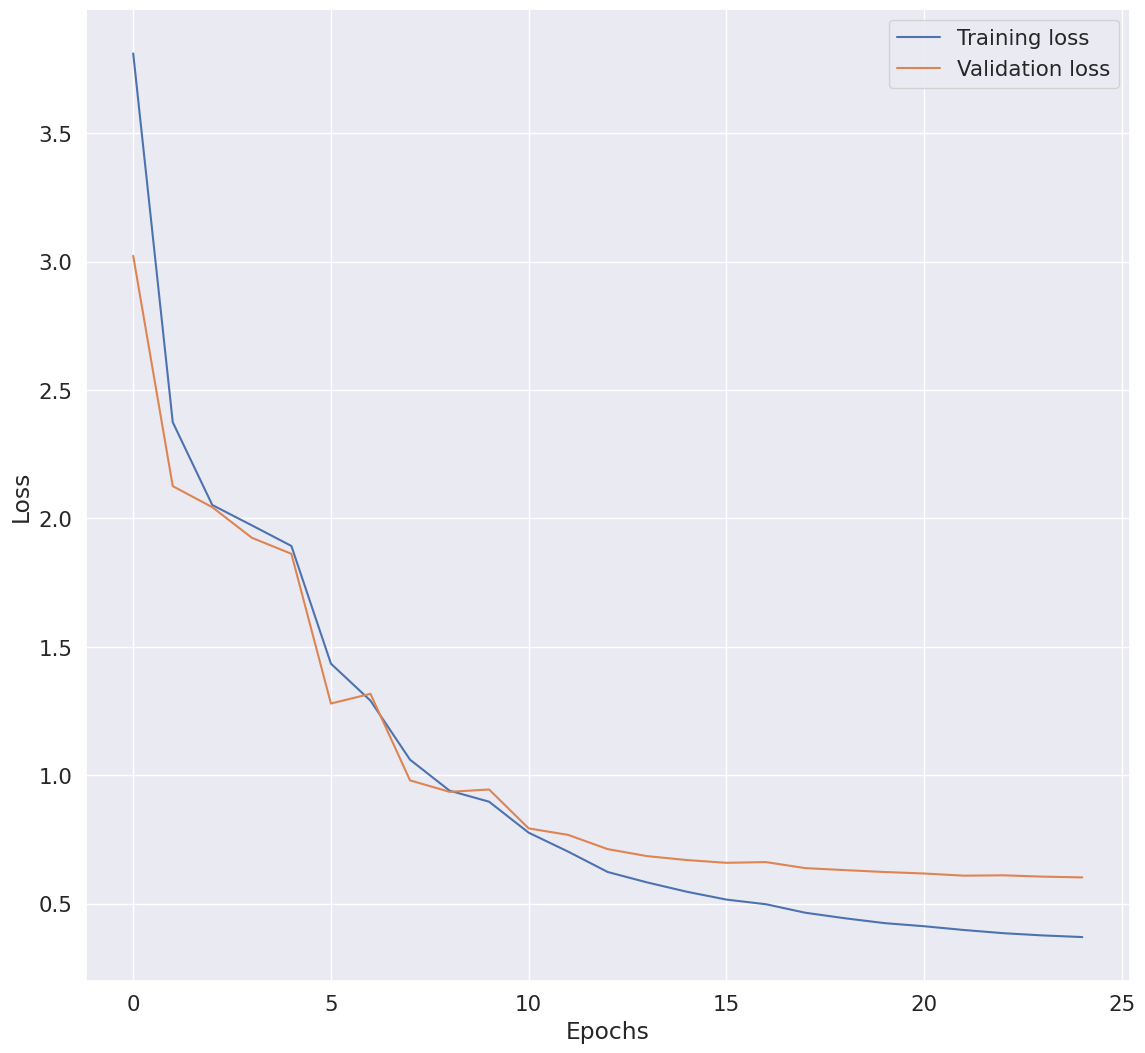

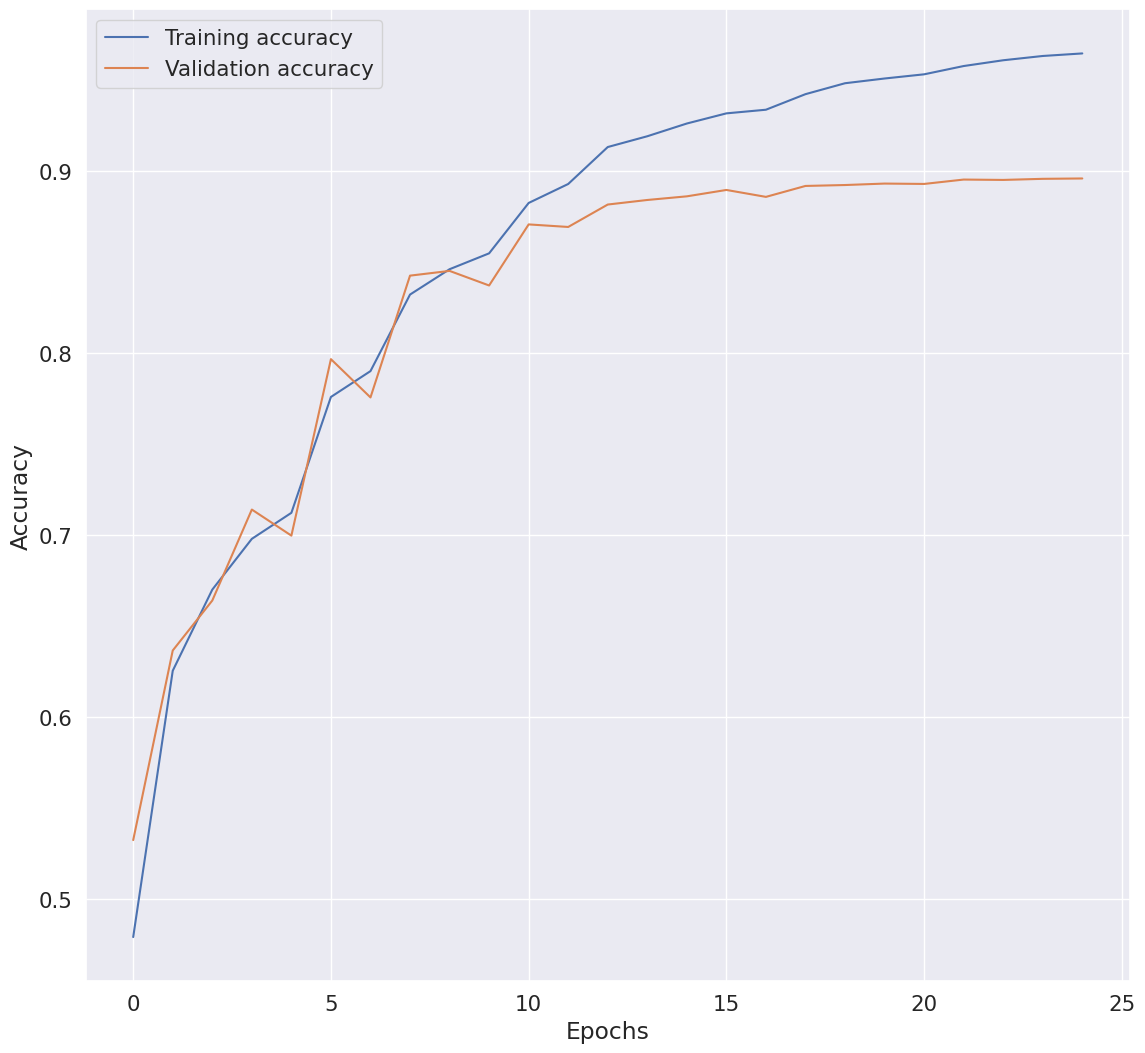

312/312 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8982 - loss: 0.6124
Test Accuracy: 0.8967347741127014, Precision: 0.8963256504786258, Recall: 0.8967347756410257, F1 Score: 0.8963134945612401
------------------------------------------------------------


In [ ]:
training_CNN(model, x_train, y_train, x_test, y_test, epochs=25)

Epoch 1/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 28s 12ms/step - accuracy: 0.4116 - loss: 4.3167 - val_accuracy: 0.4971 - val_loss: 2.8262 - learning_rate: 0.0010
Epoch 2/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.6294 - loss: 2.3123 - val_accuracy: 0.6878 - val_loss: 1.9848 - learning_rate: 0.0010
Epoch 3/20
1559/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6753 - loss: 2.0278
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6754 - loss: 2.0278 - val_accuracy: 0.6768 - val_loss: 1.9878 - learning_rate: 0.0010
Epoch 4/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7335 - loss: 1.7309 - val_accuracy: 0.7120 - val_loss: 1.6883 - learning_rate: 7.0000e-04
Epoch 5/20
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7546 - loss: 1.5584 - val_accuracy: 0.7774 - val_loss: 1.4947 - learning_rate: 7.0000e-04
Epoch 6/20
1560/1562 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - a

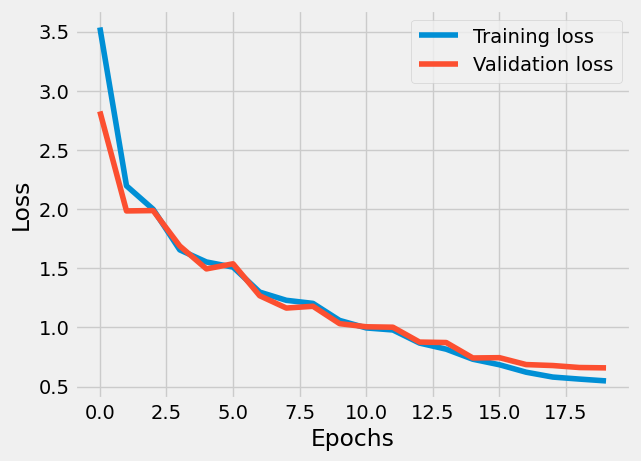

In [ ]:
history = model.fit(
    train_ds,
    validation_data= test_ds,
    epochs=20,
    callbacks=[reduce_lr]
)
plot_visualization(history)

### Epoch 20: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.9431 - loss: 0.4314 - val_accuracy: 0.9001 - val_loss: 0.5812 - learning_rate: 3.1250e-05

# Тестування моделі

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Зображення: airplane
Передбачений клас: airplane
Ймовірність: 1.00
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Зображення: automobile
Передбачений клас: automobile
Ймовірність: 0.99
------------------------------


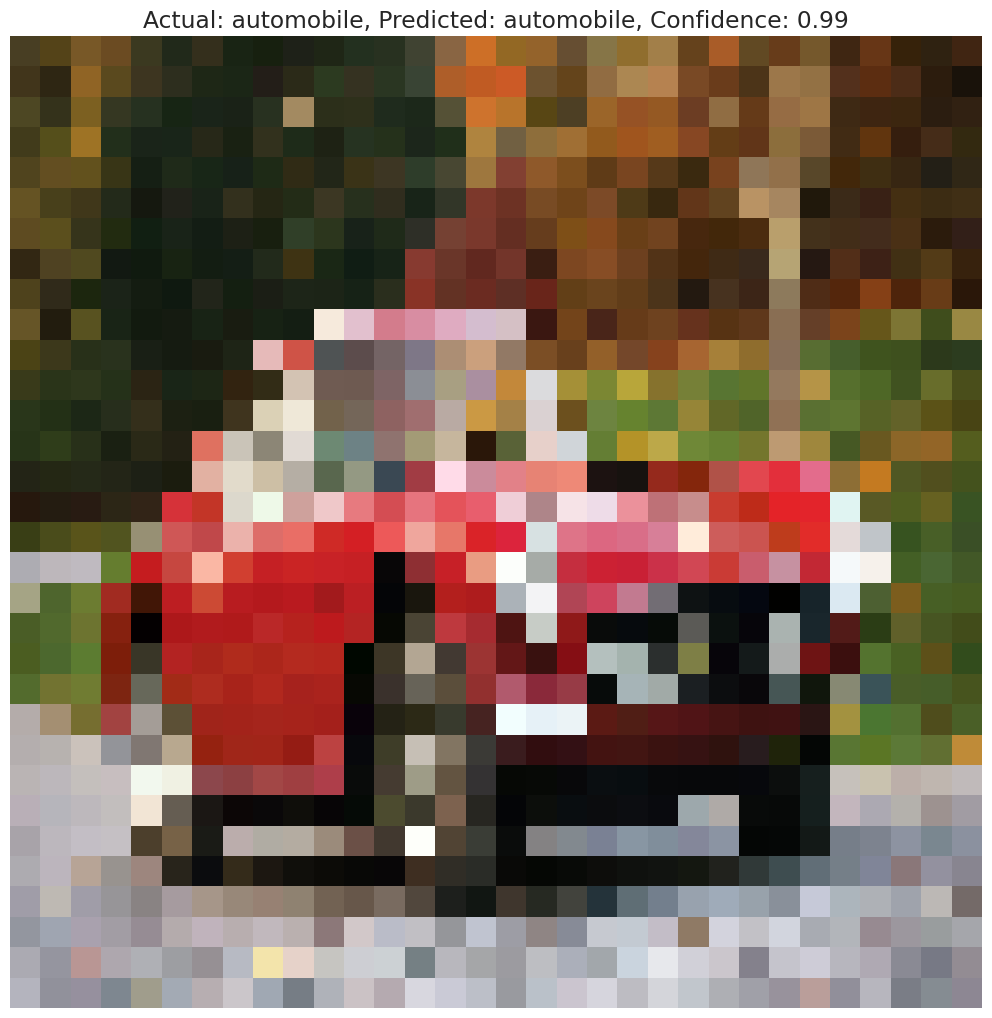

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Зображення: bird
Передбачений клас: bird
Ймовірність: 1.00
------------------------------


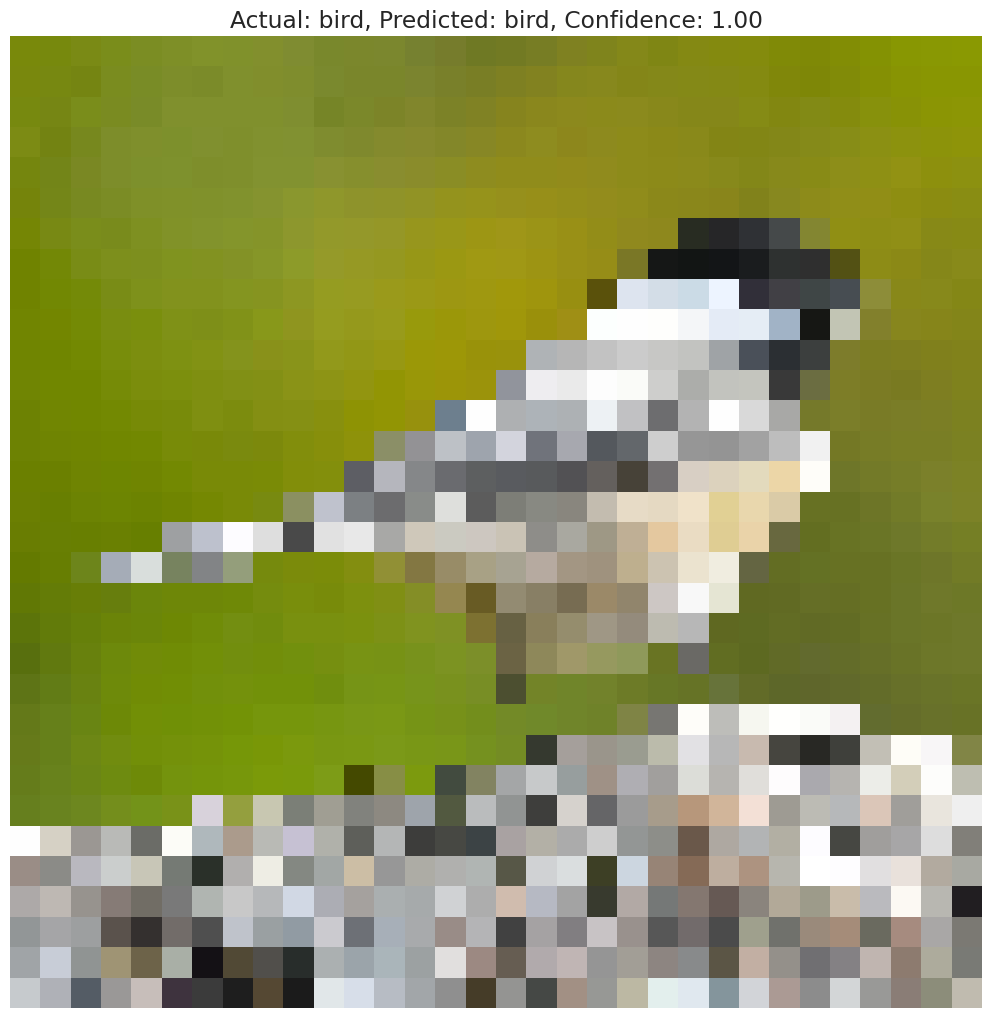

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Зображення: cat
Передбачений клас: cat
Ймовірність: 1.00
------------------------------


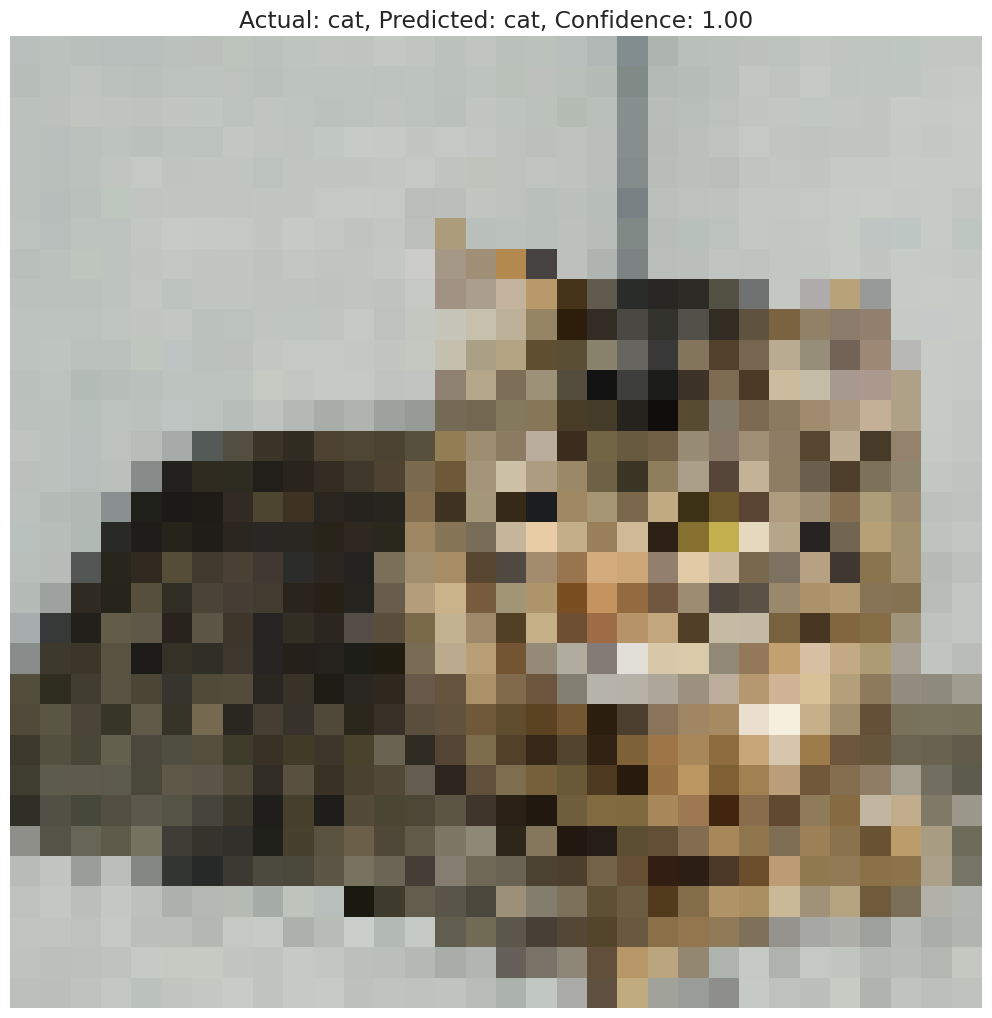

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Зображення: deer
Передбачений клас: deer
Ймовірність: 1.00
------------------------------


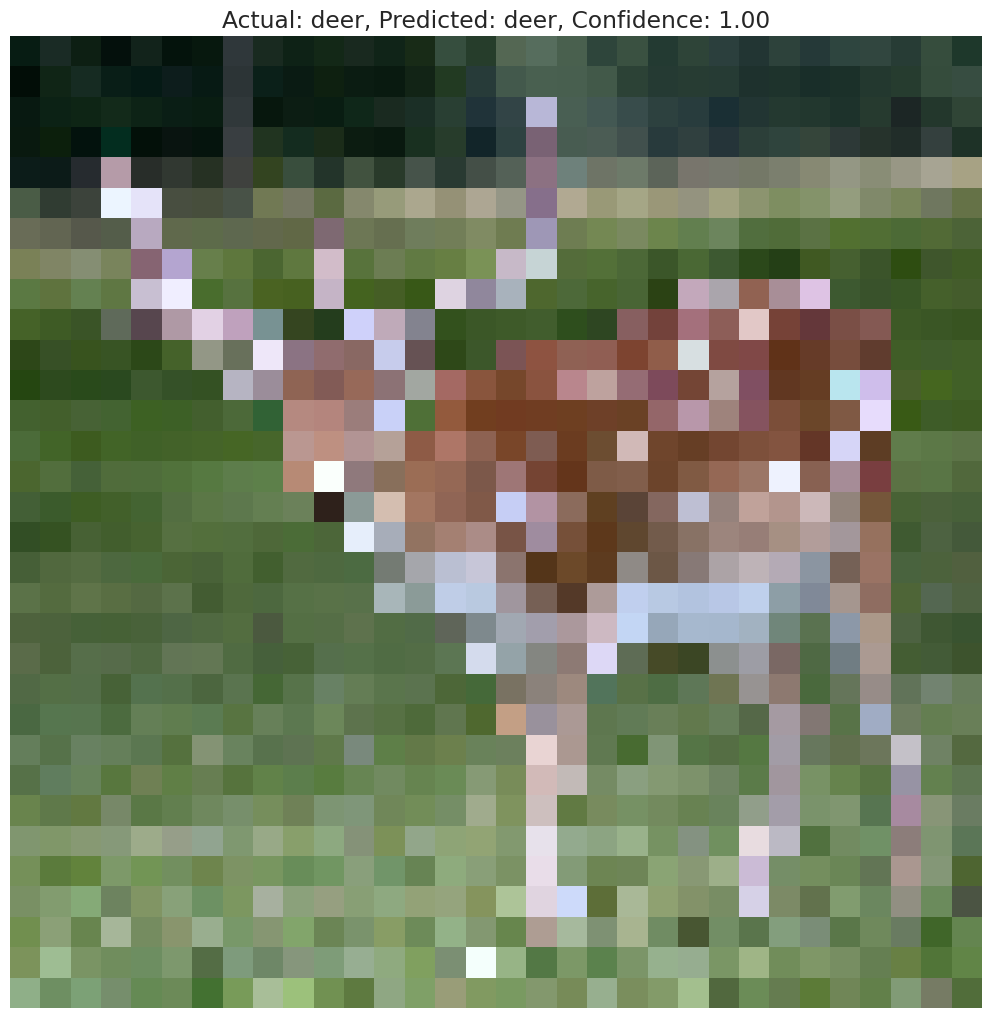

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Зображення: dog
Передбачений клас: dog
Ймовірність: 0.91
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Зображення: frog
Передбачений клас: frog
Ймовірність: 1.00
------------------------------


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Зображення: horse
Передбачений клас: deer
Ймовірність: 0.93
------------------------------


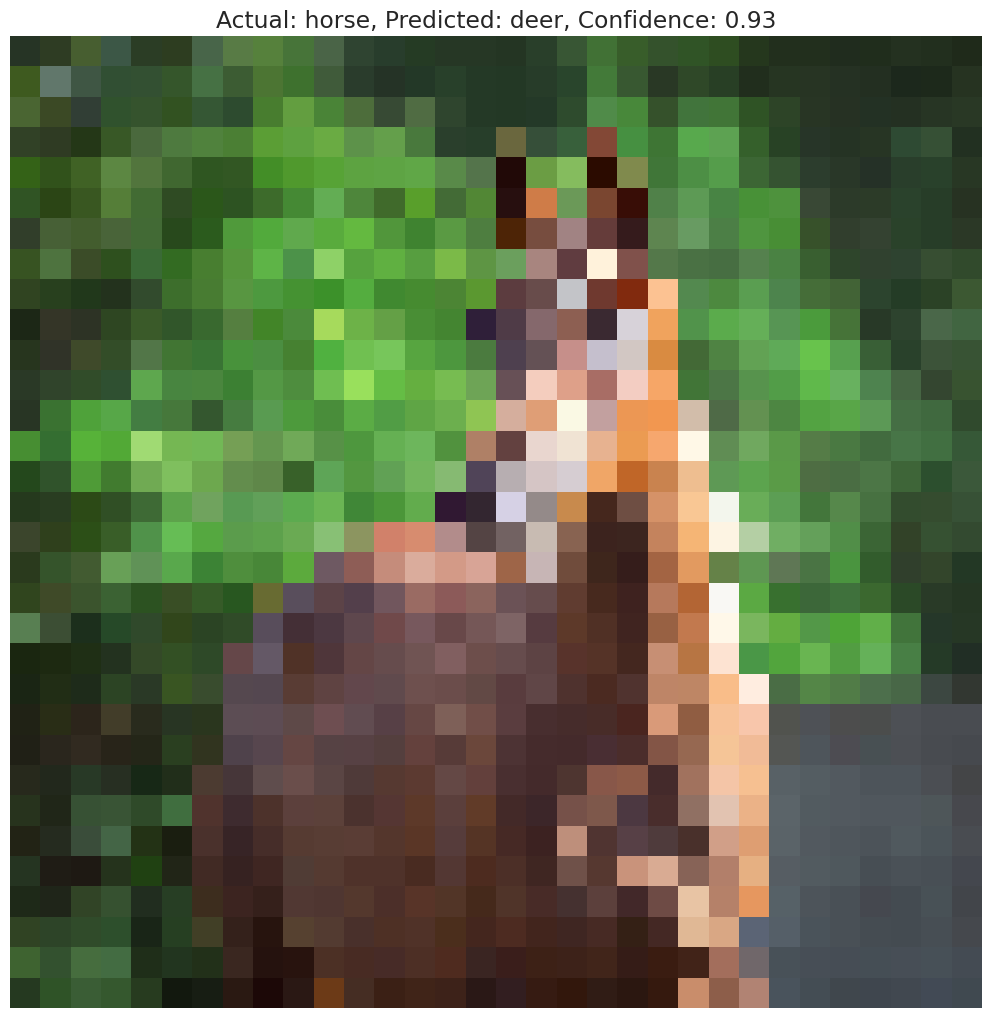

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Зображення: ship
Передбачений клас: ship
Ймовірність: 0.71
------------------------------


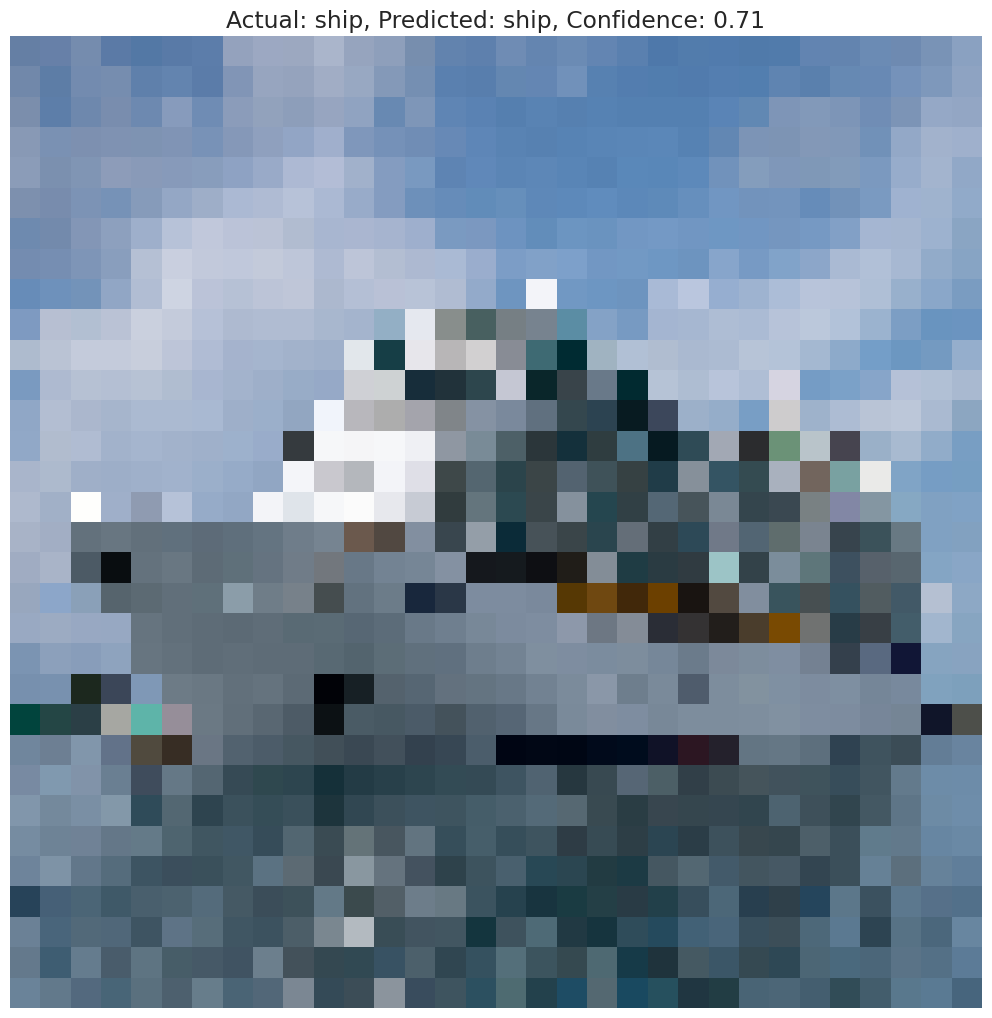

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Зображення: truck
Передбачений клас: truck
Ймовірність: 0.94
------------------------------


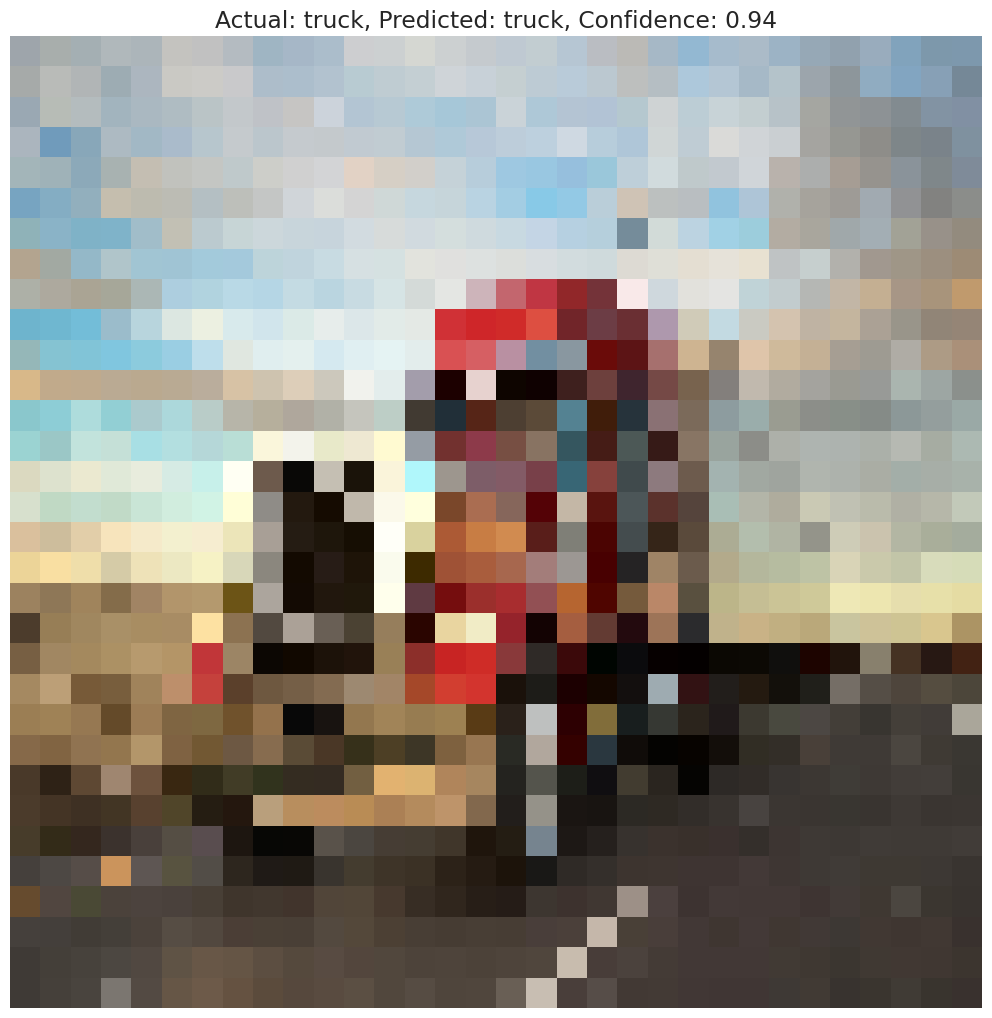

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
#train_df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/Deep Learning/Task 1/hourly_wages_data.csv")

# Шлях до директорії з власними зображеннями
image_dir = "/content/gdrive/My Drive/Colab Notebooks/my_test_images/"

# Список класів CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Завантаження моделі
#model = tf.keras.models.load_model('path_to_your_model.h5')  # Замініть на шлях до вашої моделі

# Функція для попередньої обробки зображень та передбачення
def prepare_and_predict(image_path):
    img = image.load_img(image_path, target_size=(32, 32))  # CIFAR-10 має розмір зображень 32x32
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Нормалізація зображення
    img_array = np.expand_dims(img_array, axis=0)  # Додавання виміру для батчу

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class, prediction[0][predicted_class]

# Тестування зображень з директорії
for class_name in class_names:
    image_path = os.path.join(image_dir, f"{class_name}.jpg")
    predicted_class, confidence = prepare_and_predict(image_path)

    print(f"Зображення: {class_name}")
    print(f"Передбачений клас: {class_names[predicted_class]}")
    print(f"Ймовірність: {confidence:.2f}")
    print("-" * 30)

    # Візуалізація зображення
    img = image.load_img(image_path, target_size=(32, 32))
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {class_names[predicted_class]}, Confidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()


# Висновки


Зогляду на пророблені експерименти, я дійшла до таких висновків:


*   batch size = 32 ->(64, 128) дають гірші результати ~~77%
*   при додаванні kernel_initializer='he_uniform', kernel_regularizer=l2(0.001) - дає кращі показники 84%, графіки стали плавнішими , але високий показник loss функції = 0.7 на порядок вищий попереднім результатам
*   kernel_regularizer=l2(0.001) ->плавніший графік при kernel_regularizer=l2(0.0001 і 0.01) але гірша точність, loss не впав (0.7) = результати не покращились
*   плавніше збільшення droupout - дав кращі результати
*   різна аугментція як покращує так і погіршує значно результати
*   складніша модель перенавчається, потребує більше параметрів і не виправдовує своє використання
*   використання AveragePooling2D чи MaxPooling2D не сильно вплинуло на модель, окрім як на AveragePooling2D перенавчання починається вже на 6-7 епосі







In [ ]:
df = pd.DataFrame(results)
df

Conv2D_filters  \
0                              [32, 64, 128, 256]   
1                              [32, 64, 128, 256]   
2                              [32, 64, 128, 256]   
3                              [32, 64, 128, 256]   
4  [32, 32, 64, 64, 128, 128, 256, 256, 512, 512]   
5                    [32, 64, 128, 128, 256, 256]   
6                    [32, 64, 128, 128, 256, 256]   

                                  Conv2D_kernel_size  \
0                   [(3, 3), (3, 3), (3, 3), (3, 3)]   
1                   [(3, 3), (3, 3), (3, 3), (3, 3)]   
2                   [(3, 3), (3, 3), (3, 3), (3, 3)]   
3                   [(3, 3), (3, 3), (3, 3), (3, 3)]   
4  [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3...   
5   [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]   
6   [(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]   

                                  BatchNormalization  \
0                           [True, True, True, True]   
1                           [True, True, True, True]   
2                           [True, True, True, True]   
3                           [True, True, True, True]   
4  [True, True, True, True, True, True, True, Tru...   
5               [True, True, True, True, True, True]   
6               [True, True, True, True, True, True]   

                       MaxPooling2D                    Dropout_rate  \
0  [(2, 2), (2, 2), (2, 2), (2, 2)]    [0.25, 0.25, 0.25, 0.5, 0.5]   
1  [(2, 2), (2, 2), (2, 2), (2, 2)]      [0.2, 0.25, 0.3, 0.4, 0.5]   
2  [(2, 2), (2, 2), (2, 2), (2, 2)]      [0.2, 0.25, 0.3, 0.4, 0.5]   
3  [(2, 2), (2, 2), (2, 2), (2, 2)]      [0.2, 0.25, 0.3, 0.4, 0.5]   
4                  [(2, 2), (2, 2)]  [0.2, 0.3, 0.3, 0.4, 0.4, 0.5]   
5          [(2, 2), (2, 2), (2, 2)]            [0.2, 0.3, 0.4, 0.5]   
6                          [(2, 2)]            [0.2, 0.3, 0.4, 0.5]   

  Dense_units optimizer  learning_rate  epochs  test_loss  test_accuracy  \
0   [512, 10]      adam   1.000000e-06      25   0.699270       0.760517   
1   [512, 10]      adam   1.000000e-06      25   0.621948       0.790565   
2   [512, 10]      adam   3.125000e-05      25   0.776068       0.827724   
3   [512, 10]      adam   1.000000e-06      25   0.849215       0.779046   
4   [512, 10]      adam   7.812500e-06      25   0.712744       0.862780   
5   [512, 10]      adam   1.562500e-05      25   0.650633       0.896534   
6   [512, 10]      adam   7.812500e-06      25   0.609818       0.896735   

   precision    recall        f1  total_params  
0   0.761239  0.760517  0.757371        920266  
1   0.789956  0.790565  0.788070        920266  
2   0.828640  0.827724  0.826401        920266  
3   0.781480  0.779046  0.776206        920266  
4   0.862299  0.862780  0.861849       4987946  
5   0.896420  0.896534  0.896156       3232330  
6   0.896326  0.896735  0.896313       3232330